In [1]:
# ============================================================
# Next-Quarter Outperformance Classifier (Random Forest) using 6 metrics
# Inputs: data/fs_sp500.csv, data/ohlcv_sp500.csv
# Features (ONLY these 6):
#   - PB (Price to Book) = MarketCap / BookValue
#   - RelativeReturn     = stock quarterly return - equal-weight market return
#   - BookValue          = Assets - Liabilities
#   - PE                 = MarketCap / Net Income (if NetIncome > 0 else NaN)
#   - CapEx              = PP&E Purchases + CapEx Incurred but Not Yet Paid
#   - TotalLiabilities   = Liabilities
# Target: NEXT QUARTER excess return class (5 bins from TRAIN)
# Also outputs a binary "Outperform" score via class probabilities.
# Train period: <= 2020-12-31, Test period: >= 2021-01-01
# ============================================================

import os
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# ----------------------------
# 0) Config
# ----------------------------
FS_PATH = "data/fs_sp500.csv"
PRICES_PATH = "data/ohlcv_sp500.csv"

TRAIN_END_DATE = pd.Timestamp("2020-12-31")
TEST_START_DATE = pd.Timestamp("2021-01-01")

OUT_DIR = Path("outputs_rf_sp500_6feats")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Labels used from your fundamentals file
LBL_ASSETS = "Assets"
LBL_LIAB   = "Liabilities"
LBL_NETINC = "Net Income (Loss) Attributable to Parent"
LBL_SH_OUT_MAIN = "Entity Common Stock, Shares Outstanding"
LBL_SH_OUT_ALT  = "Common Stock, Shares, Outstanding"
LBL_CAPEX_1 = "Payments to Acquire Property, Plant, and Equipment"
LBL_CAPEX_2 = "Capital Expenditures Incurred but Not yet Paid"

NEEDED_LABELS = [
    LBL_ASSETS, LBL_LIAB, LBL_NETINC,
    LBL_SH_OUT_MAIN, LBL_SH_OUT_ALT,
    LBL_CAPEX_1, LBL_CAPEX_2
]

# ----------------------------
# 1) Load fundamentals
# ----------------------------
def load_fs(path: str) -> pd.DataFrame:
    fs = pd.read_csv(path)
    for c in ["ticker","label"]:
        fs[c] = fs[c].astype(str).str.strip()
    fs["ticker"] = fs["ticker"].str.upper()
    fs["val"] = pd.to_numeric(fs["val"], errors="coerce")
    for c in ["end","filed","start"]:
        if c in fs.columns:
            fs[c] = pd.to_datetime(fs[c], errors="coerce", utc=True).dt.tz_localize(None)
    # keep only labels we need
    fs = fs[fs["label"].isin(NEEDED_LABELS)].copy()
    # de-dupe: keep latest filed per (ticker,label,end)
    fs = (fs.sort_values(["ticker","label","end","filed"])
            .drop_duplicates(subset=["ticker","label","end"], keep="last"))
    fs = fs.dropna(subset=["ticker","label","end","val"])
    return fs

fs = load_fs(FS_PATH)

# ----------------------------
# 2) Load prices & build quarterly returns + equal-weight "market"
# ----------------------------
def load_prices(path: str) -> pd.DataFrame:
    px = pd.read_csv(path)
    px["Ticker"] = px["Ticker"].astype(str).str.upper().str.strip()
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce", utc=True).dt.tz_localize(None)
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    px["Volume"] = pd.to_numeric(px["Volume"], errors="coerce")
    px = px.dropna(subset=["Ticker","Date","Close"])
    return px

px = load_prices(PRICES_PATH)

# Quarter buckets using period-end timestamps (e.g., 2024Q1 -> 2024-03-31)
px["Quarter"] = px["Date"].dt.to_period("Q").dt.to_timestamp("Q")

# Aggregate prices/volumes by quarter
q_px = (px.sort_values(["Ticker","Date"])
          .groupby(["Ticker","Quarter"])
          .agg(first_close=("Close","first"),
               last_close=("Close","last"),
               sum_volume=("Volume","sum"),
               avg_volume=("Volume","mean"),
               n_days=("Date","count"))
          .reset_index())
q_px["q_ret"] = (q_px["last_close"] / q_px["first_close"]) - 1.0

# Equal-weight market return each quarter (across tickers with data)
mkt = (q_px.groupby("Quarter")
            .agg(mkt_ret=("q_ret","mean"),
                 n=("Ticker","size"))
            .reset_index())

# Merge market back to ticker quarters
q_px = q_px.merge(mkt[["Quarter","mkt_ret"]], on="Quarter", how="left")
q_px["excess_ret"] = q_px["q_ret"] - q_px["mkt_ret"]

# ----------------------------
# 3) Pivot fundamentals wide per (Ticker, Quarter) and compute 6 features
# ----------------------------
fs["Quarter"] = fs["end"].dt.to_period("Q").dt.to_timestamp("Q")
fs_wide = (fs.rename(columns={"ticker":"Ticker"})
             .pivot_table(index=["Ticker","Quarter"],
                          columns="label",
                          values="val",
                          aggfunc="last")
             .reset_index())

# Shares Outstanding (prefer main, fallback to alt)
if LBL_SH_OUT_MAIN not in fs_wide.columns: fs_wide[LBL_SH_OUT_MAIN] = np.nan
if LBL_SH_OUT_ALT  not in fs_wide.columns: fs_wide[LBL_SH_OUT_ALT]  = np.nan
fs_wide["SharesOutstanding"] = fs_wide[LBL_SH_OUT_MAIN].fillna(fs_wide[LBL_SH_OUT_ALT])

# Ensure required columns exist
for col in [LBL_ASSETS, LBL_LIAB, LBL_NETINC, LBL_CAPEX_1, LBL_CAPEX_2]:
    if col not in fs_wide.columns:
        fs_wide[col] = np.nan

# Merge price info (last_close, excess_ret) to fundamentals
df = fs_wide.merge(q_px[["Ticker","Quarter","last_close","excess_ret"]], on=["Ticker","Quarter"], how="left")

# Derived components
df["BookValue"] = df[LBL_ASSETS] - df[LBL_LIAB]
df["CapEx"] = df[LBL_CAPEX_1].fillna(0) + df[LBL_CAPEX_2].fillna(0)
df["TotalLiabilities"] = df[LBL_LIAB]
df["MarketCap"] = df["last_close"] * df["SharesOutstanding"]

def safe_div(num, den):
    num = num.astype(float)
    den = den.astype(float)
    out = np.where((den.notna()) & (den != 0), num/den, np.nan)
    return pd.Series(out, index=num.index)

# PB
df["PB"] = safe_div(df["MarketCap"], df["BookValue"])

# PE (only if Net Income > 0)
ni = df[LBL_NETINC]
df["PE"] = np.nan
pos = ni > 0
df.loc[pos, "PE"] = safe_div(df.loc[pos, "MarketCap"], df.loc[pos, LBL_NETINC])

# Relative Return
df["RelativeReturn"] = df["excess_ret"]

# Keep only identifiers + 6 features + excess_ret for target
df = df[["Ticker","Quarter","PB","RelativeReturn","BookValue","PE","CapEx","TotalLiabilities","excess_ret"]].copy()

# ----------------------------
# 4) Build target = NEXT QUARTER excess return (5 classes)
# ----------------------------
df = df.sort_values(["Ticker","Quarter"])
df["next_excess_ret"] = df.groupby("Ticker")["excess_ret"].shift(-1)
df = df.dropna(subset=["next_excess_ret"])  # drop last quarter per ticker (no next)

# Temporal split
df["quarter_end_date"] = df["Quarter"]
train_mask = df["quarter_end_date"] <= TRAIN_END_DATE
test_mask  = df["quarter_end_date"] >= TEST_START_DATE

# Quantile bins from TRAIN ONLY
train_excess = df.loc[train_mask, "next_excess_ret"].dropna()
if len(train_excess) < 10:
    raise RuntimeError("Insufficient training samples after assembly. Check data coverage.")
q1, q2, q3, q4 = train_excess.quantile([0.2, 0.4, 0.6, 0.8]).tolist()

def label_5bin(x):
    if x <= q1: return "High Excess Loss"
    if x <= q2: return "Excess Loss"
    if x <= q3: return "Neutral"
    if x <= q4: return "Excess Return"
    return "High Excess Return"

df["target_class"] = df["next_excess_ret"].apply(label_5bin)

# ----------------------------
# 5) Prepare features (ONLY the six requested)
# ----------------------------
feature_cols = ["PB","RelativeReturn","BookValue","PE","CapEx","TotalLiabilities"]

# Impute NaNs using train medians (no leakage)
X_all = df[feature_cols].copy()
train_medians = X_all[train_mask].median(numeric_only=True)
X_all = X_all.fillna(train_medians)

y_all = df["target_class"].copy()

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]
df_train = df[train_mask].copy()
df_test  = df[test_mask].copy()

print(f"Train samples: {len(X_train):,} | Test samples: {len(X_test):,}")
print("Train class distribution:")
print(y_train.value_counts(normalize=True).round(3))

# ----------------------------
# 6) Random Forest with time-aware CV
# ----------------------------
param_grid = {
    "n_estimators": [300],
    "max_depth": [6, 10, None],
    "min_samples_leaf": [3, 5, 10],
    "max_features": ["sqrt", 0.5]
}
tscv = TimeSeriesSplit(n_splits=4)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

gcv = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
gcv.fit(X_train, y_train)
best_rf = gcv.best_estimator_
print("\nBest RF params:", gcv.best_params_)

# ----------------------------
# 7) Evaluation (5-class)
# ----------------------------
pred_train = best_rf.predict(X_train)
pred_test  = best_rf.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test  = accuracy_score(y_test,  pred_test)

print(f"\nAccuracy - train: {acc_train:.3f} | test: {acc_test:.3f}\n")
print("Classification report (TEST):")
print(classification_report(y_test, pred_test, digits=3))

labels_order = ["High Excess Loss","Excess Loss","Neutral","Excess Return","High Excess Return"]
print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, pred_test, labels=labels_order))

# ----------------------------
# 8) Convert to binary "Outperform" & compute Precision@K
# ----------------------------
# Outperform classes:
OUTPERF_CLASSES = {"High Excess Return","Excess Return"}

proba_test = pd.DataFrame(best_rf.predict_proba(X_test), columns=best_rf.classes_, index=df_test.index)

# Probability of Outperformance = P(High Excess Return) + P(Excess Return)
p_outperf = proba_test.get("High Excess Return", 0) + proba_test.get("Excess Return", 0)
df_test = df_test.assign(pred_class=pred_test, p_outperf=p_outperf.values)

# Realized binary: did it actually outperform next quarter?
df_test["y_outperf_realized"] = (df_test["next_excess_ret"] > 0).astype(int)

def precision_at_k(dfq: pd.DataFrame, k: int = 10):
    if len(dfq) == 0:
        return np.nan, np.nan
    take = min(k, len(dfq))
    top = dfq.sort_values("p_outperf", ascending=False).head(take)
    prec = top["y_outperf_realized"].mean()
    realized_avg_excess = top["next_excess_ret"].mean()
    return float(prec), float(realized_avg_excess)

# Overall Precision@K on test
K = 20
overall_prec, overall_avg_excess = precision_at_k(df_test, K)

# Per-quarter top-K summary
per_q = []
for q, g in df_test.groupby("Quarter"):
    prec_k, avg_excess = precision_at_k(g, K)
    per_q.append({"Quarter": q, f"Precision@{K}": prec_k, f"AvgNextExcess@{K}": avg_excess, "n": len(g)})
per_q_df = pd.DataFrame(per_q).sort_values("Quarter")

# ----------------------------
# 9) Save outputs
# ----------------------------
# Feature importances
imp = (pd.DataFrame({"feature": feature_cols,
                     "importance": best_rf.feature_importances_})
         .sort_values("importance", ascending=False))
imp.to_csv(OUT_DIR / "feature_importances.csv", index=False)

# Predictions (test) with probabilities and p_outperf
preds_out = (df_test[["Ticker","Quarter","PB","RelativeReturn","BookValue","PE","CapEx","TotalLiabilities",
                      "excess_ret","next_excess_ret","target_class","pred_class","p_outperf"]]
             .copy())
# Append class probabilities
preds_out = preds_out.join(proba_test, how="left")
preds_out.to_csv(OUT_DIR / "predictions_test.csv", index=False)

# Top picks per quarter (sorted by p_outperf)
top_picks = (df_test.sort_values(["Quarter","p_outperf"], ascending=[True, False])
                    .groupby("Quarter")
                    .head(K)
                    .reset_index(drop=True))
top_picks_out = top_picks[["Ticker","Quarter","p_outperf","pred_class","next_excess_ret","target_class"]]
top_picks_out.to_csv(OUT_DIR / "top_picks_by_quarter.csv", index=False)

# Per-quarter Precision@K report
per_q_df.to_csv(OUT_DIR / f"precision_at_{K}_per_quarter.csv", index=False)

# Metrics summary
with open(OUT_DIR / "metrics.txt", "w") as f:
    f.write(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}\n")
    f.write(f"Accuracy (train): {acc_train:.4f} | Accuracy (test): {acc_test:.4f}\n")
    f.write(f"Overall Precision@{K}: {overall_prec:.4f}\n")
    f.write(f"Overall Avg Next Excess Return (Top {K}): {overall_avg_excess:.4%}\n")

print(f"\nSaved files in: {OUT_DIR.resolve()}")
print(" - feature_importances.csv")
print(" - predictions_test.csv")
print(" - top_picks_by_quarter.csv")
print(f" - precision_at_{K}_per_quarter.csv")
print(" - metrics.txt")

# ----------------------------
# 10) Quick peek
# ----------------------------
print("\nTop feature importances:")
display(imp)

print(f"\nOverall Precision@{K}: {overall_prec:.3f} | Avg Next Excess (Top {K}): {overall_avg_excess:.3%}")
print("\nPer-quarter Precision@K (head):")
display(per_q_df.head(10))

print("\nSample of TEST predictions:")
display(preds_out.head(10))


Train samples: 20,474 | Test samples: 8,420
Train class distribution:
High Excess Loss      0.2
High Excess Return    0.2
Excess Return         0.2
Excess Loss           0.2
Neutral               0.2
Name: target_class, dtype: float64
Fitting 4 folds for each of 18 candidates, totalling 72 fits

Best RF params: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 300}

Accuracy - train: 0.288 | test: 0.225

Classification report (TEST):
                    precision    recall  f1-score   support

       Excess Loss      0.213     0.244     0.228      1661
     Excess Return      0.202     0.138     0.164      1582
  High Excess Loss      0.276     0.240     0.257      1834
High Excess Return      0.289     0.166     0.211      1856
           Neutral      0.187     0.347     0.243      1487

          accuracy                          0.225      8420
         macro avg      0.233     0.227     0.221      8420
      weighted avg      0.237     0.225     0.221 

,feature,importance
1,RelativeReturn,0.284188
5,TotalLiabilities,0.189963
2,BookValue,0.187854
0,PB,0.129638
3,PE,0.119427
4,CapEx,0.088930



Overall Precision@20: 0.450 | Avg Next Excess (Top 20): 2.790%

Per-quarter Precision@K (head):


,Quarter,Precision@20,AvgNextExcess@20,n
0,2021-03-31,0.55,0.039991,488
1,2021-06-30,0.55,0.039181,490
2,2021-09-30,0.35,0.012865,490
3,2021-12-31,0.35,-0.027741,493
4,2022-03-31,0.60,0.043839,490
5,2022-06-30,0.65,0.077342,492
6,2022-09-30,0.70,0.067742,494
7,2022-12-31,0.60,0.122929,496
8,2023-03-31,0.55,0.081138,492
9,2023-06-30,0.35,-0.014786,495



Sample of TEST predictions:


,Ticker,Quarter,PB,RelativeReturn,BookValue,PE,CapEx,TotalLiabilities,excess_ret,next_excess_ret,target_class,pred_class,p_outperf,Excess Loss,Excess Return,High Excess Loss,High Excess Return,Neutral
51,A,2021-03-31,7.823025,-0.052297,4.804000e+09,130.492400,41000000.0,4.870000e+09,-0.052297,0.096859,High Excess Return,Excess Return,0.392965,0.206530,0.214149,0.196177,0.178817,0.204328
52,A,2021-06-30,9.059893,0.096859,4.810000e+09,201.750387,72000000.0,5.588000e+09,0.096859,0.070719,Excess Return,Excess Return,0.392422,0.208457,0.214405,0.194423,0.178017,0.204698
53,A,2021-09-30,9.380186,0.070719,4.946000e+09,175.736369,126000000.0,5.545000e+09,0.070719,-0.061326,Excess Loss,Excess Return,0.393316,0.207016,0.214274,0.194525,0.179042,0.205144
54,A,2021-12-31,8.714984,-0.061326,5.389000e+09,38.814091,188000000.0,5.316000e+09,-0.061326,-0.129708,High Excess Loss,Excess Return,0.401520,0.201879,0.211805,0.187159,0.189715,0.209442
55,A,2022-03-31,7.515687,-0.129708,5.154000e+09,136.875799,75000000.0,5.173000e+09,-0.129708,0.033158,Excess Return,High Excess Loss,0.403602,0.195012,0.190195,0.236598,0.213407,0.164789
56,A,2022-06-30,6.766512,0.033158,5.122000e+09,126.489314,139000000.0,5.333000e+09,0.033158,0.061926,Excess Return,Excess Return,0.392210,0.208231,0.214414,0.193688,0.177796,0.205870
57,A,2022-09-30,6.917074,0.061926,5.091000e+09,107.035941,221000000.0,5.393000e+09,0.061926,0.100230,High Excess Return,Excess Return,0.390671,0.208106,0.212688,0.195516,0.177983,0.205707
58,A,2022-12-31,8.199856,0.100230,5.305000e+09,34.689184,291000000.0,5.227000e+09,0.100230,-0.132374,High Excess Loss,Excess Return,0.401351,0.202330,0.212101,0.188864,0.189249,0.207454
59,A,2023-03-31,7.160345,-0.132374,5.609000e+09,114.097661,76000000.0,5.310000e+09,-0.132374,-0.182398,High Excess Loss,High Excess Loss,0.402779,0.192526,0.189819,0.239002,0.212960,0.165692
60,A,2023-06-30,6.053549,-0.182398,5.781000e+09,115.879353,133000000.0,5.011000e+09,-0.182398,-0.022319,Neutral,High Excess Loss,0.403421,0.193264,0.189012,0.238305,0.214409,0.165010


Train samples: 20,474 | Test samples: 8,420
Train label balance (1=outperform): 0.479
Fitting 4 folds for each of 18 candidates, totalling 72 fits

Best RF params: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 300}

AUC-ROC  - train: 0.602 | test: 0.517
AvgPrec  - train: 0.592 | test: 0.495
Accuracy - train: 0.568 | test: 0.527

Overall Precision@20: 0.450 | Avg Next Excess (Top 20): 9.083%


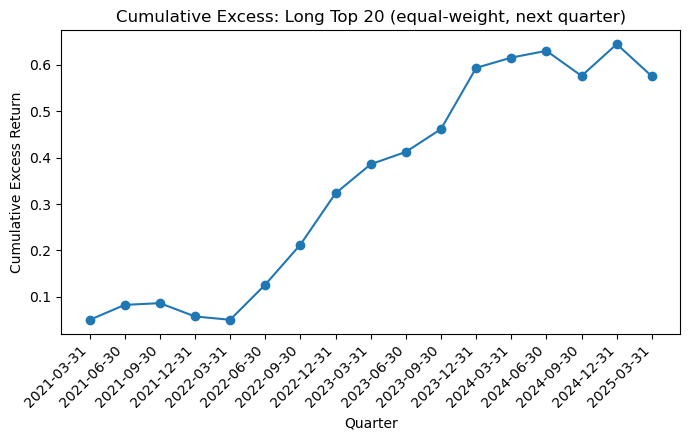

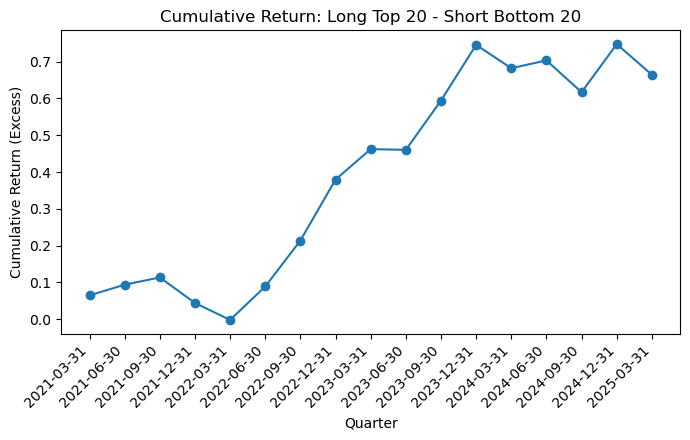


Saved files in: /Users/x/Documents/UOL/year3_2/FinalProject/feature prototype/outputs_rf_sp500_binary
 - feature_importances.csv
 - predictions_test_binary.csv
 - top_20_picks_by_quarter.csv
 - precision_at_20_per_quarter.csv
 - portfolio_timeseries.csv
 - cum_excess_long_top_*.png, cum_return_long_short_*.png

Top feature importances:


,feature,importance
2,BookValue,0.207963
5,TotalLiabilities,0.203058
0,PB,0.172580
3,PE,0.147454
4,CapEx,0.141502
1,RelativeReturn,0.127443



Per-quarter Precision@K (head):


,Quarter,Precision@20,AvgNextExcess@20,n
0,2021-03-31,0.55,0.050354,488
1,2021-06-30,0.60,0.030849,490
2,2021-09-30,0.30,0.003509,490
3,2021-12-31,0.45,-0.026411,493
4,2022-03-31,0.40,-0.006805,490
5,2022-06-30,0.60,0.072166,492
6,2022-09-30,0.75,0.076474,494
7,2022-12-31,0.60,0.091173,496
8,2023-03-31,0.50,0.047286,492
9,2023-06-30,0.45,0.019237,495



Portfolio summary (tail):


,long_excess,short_excess,long_only,long_short,cum_long_only,cum_long_short
Quarter,,,,,,
2022-12-31,0.091173,-0.045481,0.091173,0.136654,0.323188,0.379489
2023-03-31,0.047286,-0.012771,0.047286,0.060057,0.385756,0.462337
2023-06-30,0.019237,0.020680,0.019237,-0.001443,0.412414,0.460227
2023-09-30,0.034803,-0.057099,0.034803,0.091902,0.461571,0.594425
2023-12-31,0.090236,-0.004766,0.090236,0.095001,0.593457,0.745898
2024-03-31,0.013888,0.050350,0.013888,-0.036462,0.615587,0.682238
2024-06-30,0.009040,-0.003679,0.009040,0.012718,0.630191,0.703634
2024-09-30,-0.033166,0.017683,-0.033166,-0.050849,0.576123,0.617005
2024-12-31,0.043468,-0.037466,0.043468,0.080934,0.644634,0.747875


In [3]:
# ============================================================
# Next-Quarter Outperformer Ranking (Binary) using 6 metrics
# Features:
#   PB, PE, BookValue, CapEx, TotalLiabilities, RelativeReturn
# Label:
#   y = 1{ next_excess_ret > 0 }, i.e., beats the market next quarter
# Model:
#   RandomForestClassifier (time-aware CV), outputs P(outperform)
# Outputs:
#   - Precision@K, AvgNextExcess@K
#   - Cumulative returns for Long-TopK and LongTopK-ShortBottomK
#   - CSVs + plots
# ============================================================

import os
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

# ----------------------------
# 0) Config
# ----------------------------
FS_PATH = "data/fs_sp500.csv"
PRICES_PATH = "data/ohlcv_sp500.csv"

TRAIN_END_DATE = pd.Timestamp("2020-12-31")
TEST_START_DATE = pd.Timestamp("2021-01-01")

TOP_K = 20  # number of top names per quarter for evaluation/portfolio

OUT_DIR = Path("outputs_rf_sp500_binary")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Labels used from your fundamentals file
LBL_ASSETS = "Assets"
LBL_LIAB   = "Liabilities"
LBL_NETINC = "Net Income (Loss) Attributable to Parent"
LBL_SH_OUT_MAIN = "Entity Common Stock, Shares Outstanding"
LBL_SH_OUT_ALT  = "Common Stock, Shares, Outstanding"
LBL_CAPEX_1 = "Payments to Acquire Property, Plant, and Equipment"
LBL_CAPEX_2 = "Capital Expenditures Incurred but Not yet Paid"

NEEDED_LABELS = [
    LBL_ASSETS, LBL_LIAB, LBL_NETINC,
    LBL_SH_OUT_MAIN, LBL_SH_OUT_ALT,
    LBL_CAPEX_1, LBL_CAPEX_2
]

# ----------------------------
# 1) Load fundamentals
# ----------------------------
def load_fs(path: str) -> pd.DataFrame:
    fs = pd.read_csv(path)
    for c in ["ticker","label"]:
        fs[c] = fs[c].astype(str).str.strip()
    fs["ticker"] = fs["ticker"].str.upper()
    fs["val"] = pd.to_numeric(fs["val"], errors="coerce")
    for c in ["end","filed","start"]:
        if c in fs.columns:
            fs[c] = pd.to_datetime(fs[c], errors="coerce", utc=True).dt.tz_localize(None)
    fs = fs[fs["label"].isin(NEEDED_LABELS)].copy()
    fs = (fs.sort_values(["ticker","label","end","filed"])
             .drop_duplicates(subset=["ticker","label","end"], keep="last"))
    fs = fs.dropna(subset=["ticker","label","end","val"])
    return fs

fs = load_fs(FS_PATH)

# ----------------------------
# 2) Load prices & build quarterly returns + equal-weight "market"
# ----------------------------
def load_prices(path: str) -> pd.DataFrame:
    px = pd.read_csv(path)
    px["Ticker"] = px["Ticker"].astype(str).str.upper().str.strip()
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce", utc=True).dt.tz_localize(None)
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    px["Volume"] = pd.to_numeric(px["Volume"], errors="coerce")
    px = px.dropna(subset=["Ticker","Date","Close"])
    return px

px = load_prices(PRICES_PATH)
px["Quarter"] = px["Date"].dt.to_period("Q").dt.to_timestamp("Q")

q_px = (px.sort_values(["Ticker","Date"])
          .groupby(["Ticker","Quarter"])
          .agg(first_close=("Close","first"),
               last_close=("Close","last"),
               sum_volume=("Volume","sum"),
               avg_volume=("Volume","mean"),
               n_days=("Date","count"))
          .reset_index())
q_px["q_ret"] = (q_px["last_close"] / q_px["first_close"]) - 1.0

# Equal-weight market return each quarter
mkt = (q_px.groupby("Quarter")
            .agg(mkt_ret=("q_ret","mean"),
                 n=("Ticker","size"))
            .reset_index())

q_px = q_px.merge(mkt[["Quarter","mkt_ret"]], on="Quarter", how="left")
q_px["excess_ret"] = q_px["q_ret"] - q_px["mkt_ret"]

# ----------------------------
# 3) Pivot fundamentals wide, compute the 6 features
# ----------------------------
fs["Quarter"] = fs["end"].dt.to_period("Q").dt.to_timestamp("Q")
fs_wide = (fs.rename(columns={"ticker":"Ticker"})
             .pivot_table(index=["Ticker","Quarter"],
                          columns="label",
                          values="val",
                          aggfunc="last")
             .reset_index())

# Shares Outstanding (prefer main, fallback to alt)
fs_wide[LBL_SH_OUT_MAIN] = fs_wide.get(LBL_SH_OUT_MAIN, np.nan)
fs_wide[LBL_SH_OUT_ALT]  = fs_wide.get(LBL_SH_OUT_ALT,  np.nan)
fs_wide["SharesOutstanding"] = fs_wide[LBL_SH_OUT_MAIN].fillna(fs_wide[LBL_SH_OUT_ALT])

# Ensure required columns exist
for col in [LBL_ASSETS, LBL_LIAB, LBL_NETINC, LBL_CAPEX_1, LBL_CAPEX_2]:
    if col not in fs_wide.columns:
        fs_wide[col] = np.nan

# Merge price info to fundamentals
df = fs_wide.merge(q_px[["Ticker","Quarter","last_close","excess_ret"]],
                   on=["Ticker","Quarter"], how="left")

# Derived components
df["BookValue"] = df[LBL_ASSETS] - df[LBL_LIAB]
df["CapEx"] = df[LBL_CAPEX_1].fillna(0) + df[LBL_CAPEX_2].fillna(0)
df["TotalLiabilities"] = df[LBL_LIAB]
df["MarketCap"] = df["last_close"] * df["SharesOutstanding"]

def safe_div(num, den):
    num = num.astype(float)
    den = den.astype(float)
    return pd.Series(np.where((den.notna()) & (den != 0), num/den, np.nan), index=num.index)

# PB
df["PB"] = safe_div(df["MarketCap"], df["BookValue"])

# PE (only if Net Income > 0)
df["PE"] = np.nan
ni = df[LBL_NETINC]
pos = ni > 0
df.loc[pos, "PE"] = safe_div(df.loc[pos, "MarketCap"], df.loc[pos, LBL_NETINC])

# Relative Return (current quarter)
df["RelativeReturn"] = df["excess_ret"]

# Keep identifiers, features, and excess_ret for future label
df = df[["Ticker","Quarter","PB","PE","BookValue","CapEx","TotalLiabilities","RelativeReturn","excess_ret"]].copy()

# ----------------------------
# 4) Binary label: next-quarter outperformance
# ----------------------------
df = df.sort_values(["Ticker","Quarter"])
df["next_excess_ret"] = df.groupby("Ticker")["excess_ret"].shift(-1)
df = df.dropna(subset=["next_excess_ret"])  # drop last quarter per ticker
df["y_outperf"] = (df["next_excess_ret"] > 0).astype(int)

# Temporal split
df["quarter_end_date"] = df["Quarter"]
train_mask = df["quarter_end_date"] <= TRAIN_END_DATE
test_mask  = df["quarter_end_date"] >= TEST_START_DATE

# ----------------------------
# 5) Train RandomForest on the 6 features to predict P(outperform)
# ----------------------------
feature_cols = ["PB","RelativeReturn","BookValue","PE","CapEx","TotalLiabilities"]

X_all = df[feature_cols].copy()
# Impute with train medians only (no leakage)
train_medians = X_all[train_mask].median(numeric_only=True)
X_all = X_all.fillna(train_medians)

y_all = df["y_outperf"].copy()

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]
df_train = df[train_mask].copy()
df_test  = df[test_mask].copy()

print(f"Train samples: {len(X_train):,} | Test samples: {len(X_test):,}")
print("Train label balance (1=outperform):", y_train.mean().round(3))

# Time-aware CV & grid
param_grid = {
    "n_estimators": [300],
    "max_depth": [6, 10, None],
    "min_samples_leaf": [3, 5, 10],
    "max_features": ["sqrt", 0.5]
}
tscv = TimeSeriesSplit(n_splits=4)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
gcv = GridSearchCV(rf, param_grid, cv=tscv, scoring="roc_auc", n_jobs=-1, verbose=1)
gcv.fit(X_train, y_train)
best_rf = gcv.best_estimator_
print("\nBest RF params:", gcv.best_params_)

# Probabilities
p_train = best_rf.predict_proba(X_train)[:, 1]
p_test  = best_rf.predict_proba(X_test)[:, 1]

# Metrics
roc_train = roc_auc_score(y_train, p_train)
roc_test  = roc_auc_score(y_test,  p_test)
ap_train  = average_precision_score(y_train, p_train)
ap_test   = average_precision_score(y_test,  p_test)
acc_train = accuracy_score(y_train, (p_train>=0.5).astype(int))
acc_test  = accuracy_score(y_test,  (p_test>=0.5).astype(int))

print(f"\nAUC-ROC  - train: {roc_train:.3f} | test: {roc_test:.3f}")
print(f"AvgPrec  - train: {ap_train:.3f} | test: {ap_test:.3f}")
print(f"Accuracy - train: {acc_train:.3f} | test: {acc_test:.3f}")

# ----------------------------
# 6) Ranking evaluation: Precision@K & AvgNextExcess@K
# ----------------------------
df_test = df_test.assign(p_outperf=p_test)

def precision_at_k(dfq: pd.DataFrame, k: int) -> tuple[float,float]:
    if len(dfq) == 0: return np.nan, np.nan
    take = min(k, len(dfq))
    top = dfq.sort_values("p_outperf", ascending=False).head(take)
    prec = top["y_outperf"].mean()
    avg_next_excess = top["next_excess_ret"].mean()
    return float(prec), float(avg_next_excess)

overall_prec, overall_avg_excess = precision_at_k(df_test, TOP_K)
print(f"\nOverall Precision@{TOP_K}: {overall_prec:.3f} | Avg Next Excess (Top {TOP_K}): {overall_avg_excess:.3%}")

# Per-quarter Precision@K
per_q = []
for q, g in df_test.groupby("Quarter"):
    prec_k, avg_excess = precision_at_k(g, TOP_K)
    per_q.append({"Quarter": q, f"Precision@{TOP_K}": prec_k, f"AvgNextExcess@{TOP_K}": avg_excess, "n": len(g)})
per_q_df = pd.DataFrame(per_q).sort_values("Quarter")

# ----------------------------
# 7) Portfolio backtest: Long Top-K and LongTopK - ShortBottomK
# ----------------------------
# For each quarter, take equal-weight Top-K by p_outperf; realized next_excess_ret is future return.
def top_k_by_quarter(dfq: pd.DataFrame, k: int, col="p_outperf", ascending=False):
    return (dfq.sort_values([col], ascending=ascending)
               .groupby("Quarter")
               .head(k)
               .reset_index(drop=True))

def bottom_k_by_quarter(dfq: pd.DataFrame, k: int, col="p_outperf", ascending=True):
    return top_k_by_quarter(dfq, k, col=col, ascending=ascending)

topK = top_k_by_quarter(df_test, TOP_K, col="p_outperf", ascending=False)
botK = bottom_k_by_quarter(df_test, TOP_K, col="p_outperf", ascending=True)

# Quarter-level realized returns (average excess of constituents)
long_by_q = topK.groupby("Quarter")["next_excess_ret"].mean().rename("long_excess")
short_by_q = botK.groupby("Quarter")["next_excess_ret"].mean().rename("short_excess")
port = pd.concat([long_by_q, short_by_q], axis=1).fillna(0.0)
port["long_only"] = port["long_excess"]
port["long_short"] = port["long_excess"] - port["short_excess"]

# Cumulative curves
port = port.sort_index()
port["cum_long_only"] = (1 + port["long_only"]).cumprod() - 1
port["cum_long_short"] = (1 + port["long_short"]).cumprod() - 1

# ----------------------------
# 8) Save outputs
# ----------------------------
# Feature importances
imp = (pd.DataFrame({"feature": feature_cols,
                     "importance": best_rf.feature_importances_})
         .sort_values("importance", ascending=False))
imp.to_csv(OUT_DIR / "feature_importances.csv", index=False)

# Predictions (test) with p_outperf
preds_out = df_test[["Ticker","Quarter","PB","PE","BookValue","CapEx","TotalLiabilities",
                     "RelativeReturn","excess_ret","next_excess_ret","y_outperf","p_outperf"]].copy()
preds_out.to_csv(OUT_DIR / "predictions_test_binary.csv", index=False)

# Top picks per quarter
top_picks = (df_test.sort_values(["Quarter","p_outperf"], ascending=[True, False])
                    .groupby("Quarter").head(TOP_K).reset_index(drop=True))
top_picks_out = top_picks[["Ticker","Quarter","p_outperf","next_excess_ret","y_outperf"]]
top_picks_out.to_csv(OUT_DIR / f"top_{TOP_K}_picks_by_quarter.csv", index=False)

# Per-quarter metrics
per_q_df.to_csv(OUT_DIR / f"precision_at_{TOP_K}_per_quarter.csv", index=False)

# Summary metrics
with open(OUT_DIR / "metrics.txt", "w") as f:
    f.write(f"AUC-ROC train/test: {roc_train:.4f}/{roc_test:.4f}\n")
    f.write(f"AvgPrecision train/test: {ap_train:.4f}/{ap_test:.4f}\n")
    f.write(f"Accuracy train/test: {acc_train:.4f}/{acc_test:.4f}\n")
    f.write(f"Overall Precision@{TOP_K}: {overall_prec:.4f}\n")
    f.write(f"Overall Avg Next Excess (Top {TOP_K}): {overall_avg_excess:.4%}\n")

# Portfolio time series
port.to_csv(OUT_DIR / "portfolio_timeseries.csv")

# ----------------------------
# 9) Plots
# ----------------------------
plt.figure(figsize=(7,4.5))
plt.plot(port.index.astype(str), port["cum_long_only"], marker="o")
plt.title(f"Cumulative Excess: Long Top {TOP_K} (equal-weight, next quarter)")
plt.xlabel("Quarter")
plt.ylabel("Cumulative Excess Return")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(OUT_DIR / f"cum_excess_long_top_{TOP_K}.png", dpi=150)
plt.show()

plt.figure(figsize=(7,4.5))
plt.plot(port.index.astype(str), port["cum_long_short"], marker="o")
plt.title(f"Cumulative Return: Long Top {TOP_K} - Short Bottom {TOP_K}")
plt.xlabel("Quarter")
plt.ylabel("Cumulative Return (Excess)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(OUT_DIR / f"cum_return_long_short_{TOP_K}.png", dpi=150)
plt.show()

print(f"\nSaved files in: {OUT_DIR.resolve()}")
print(" - feature_importances.csv")
print(" - predictions_test_binary.csv")
print(f" - top_{TOP_K}_picks_by_quarter.csv")
print(f" - precision_at_{TOP_K}_per_quarter.csv")
print(" - portfolio_timeseries.csv")
print(" - cum_excess_long_top_*.png, cum_return_long_short_*.png")

print("\nTop feature importances:")
display(imp.head(10))

print("\nPer-quarter Precision@K (head):")
display(per_q_df.head(10))

print("\nPortfolio summary (tail):")
display(port.tail(10))


In [7]:
# ============================================================
# Next-Quarter Outperformer Ranking (Binary) with Model Zoo + Robustness Fixes
# - Features:
#     * Core 6: PB, PE, BookValue, CapEx, TotalLiabilities, RelativeReturn
#     * QoQ/YoY deltas (safe), logs, return lags, daily volatility
# - Label: y_outperf = 1{ next_excess_ret > 0 }
# - Models: RF, HistGB, GB, Logistic (scaled)
# - Fixes: safe pct_change, replace ±inf -> NaN, train-wise winsorize, train-only impute
# - Outputs: metrics, per-quarter Precision@K, portfolio curves, per-model CSVs/plots
# ============================================================

import os
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="invalid value encountered", category=RuntimeWarning)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
try:
    from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
except Exception:
    pass
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

# ----------------------------
# 0) Config
# ----------------------------
FS_PATH = "data/fs_sp500.csv"
PRICES_PATH = "data/ohlcv_sp500.csv"

TRAIN_END_DATE = pd.Timestamp("2020-12-31")
TEST_START_DATE = pd.Timestamp("2021-01-01")
TOP_K = 20

BASE_OUT = Path("outputs_sp500_model_compare")
BASE_OUT.mkdir(parents=True, exist_ok=True)

# Fundamentals labels in fs_sp500.csv
LBL_ASSETS = "Assets"
LBL_LIAB   = "Liabilities"
LBL_NETINC = "Net Income (Loss) Attributable to Parent"
LBL_SH_OUT_MAIN = "Entity Common Stock, Shares Outstanding"
LBL_SH_OUT_ALT  = "Common Stock, Shares, Outstanding"
LBL_CAPEX_1 = "Payments to Acquire Property, Plant, and Equipment"
LBL_CAPEX_2 = "Capital Expenditures Incurred but Not yet Paid"

NEEDED_LABELS = [
    LBL_ASSETS, LBL_LIAB, LBL_NETINC,
    LBL_SH_OUT_MAIN, LBL_SH_OUT_ALT,
    LBL_CAPEX_1, LBL_CAPEX_2
]

# ----------------------------
# Helpers (robust transforms)
# ----------------------------
def pct_change_safe(s: pd.Series, periods: int) -> pd.Series:
    """Like pct_change, but treats zero lag as missing (avoids ±inf)."""
    prev = s.shift(periods)
    return (s - prev) / prev.replace(0, np.nan)

def winsorize_df_trainwise(X_all: pd.DataFrame, train_mask: pd.Series, low_q=0.01, high_q=0.99) -> pd.DataFrame:
    """Clip each feature to [q_low, q_high] computed on TRAIN ONLY."""
    X = X_all.copy()
    train_X = X.loc[train_mask]
    q_low = train_X.quantile(low_q, numeric_only=True)
    q_high = train_X.quantile(high_q, numeric_only=True)
    for c in X.columns:
        if c in q_low.index:
            X[c] = X[c].clip(lower=q_low[c], upper=q_high[c])
    return X

def safe_div(num, den):
    num = num.astype(float)
    den = den.astype(float)
    return pd.Series(np.where((den.notna()) & (den != 0), num/den, np.nan), index=num.index)

def safe_log1p(x: pd.Series) -> pd.Series:
    x = x.astype(float)
    # log1p for x > -1; otherwise NaN
    mask = x > -1
    out = pd.Series(np.nan, index=x.index, dtype=float)
    out[mask] = np.log1p(x[mask])
    return out

# ----------------------------
# 1) Loaders
# ----------------------------
def load_fs(path: str) -> pd.DataFrame:
    fs = pd.read_csv(path)
    for c in ["ticker","label"]:
        fs[c] = fs[c].astype(str).str.strip()
    fs["ticker"] = fs["ticker"].str.upper()
    fs["val"] = pd.to_numeric(fs["val"], errors="coerce")
    for c in ["end","filed","start"]:
        if c in fs.columns:
            fs[c] = pd.to_datetime(fs[c], errors="coerce", utc=True).dt.tz_localize(None)
    fs = fs[fs["label"].isin(NEEDED_LABELS)].copy()
    fs = (fs.sort_values(["ticker","label","end","filed"])
             .drop_duplicates(subset=["ticker","label","end"], keep="last"))
    fs = fs.dropna(subset=["ticker","label","end","val"])
    return fs

def load_prices(path: str) -> pd.DataFrame:
    px = pd.read_csv(path)
    px["Ticker"] = px["Ticker"].astype(str).str.upper().str.strip()
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce", utc=True).dt.tz_localize(None)
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    px["Volume"] = pd.to_numeric(px["Volume"], errors="coerce")
    px = px.dropna(subset=["Ticker","Date","Close"])
    return px

# ----------------------------
# 2) Ingest & Quarterly Aggregates
# ----------------------------
fs = load_fs(FS_PATH)
px = load_prices(PRICES_PATH)

# Daily returns & quarterly volatility
px = px.sort_values(["Ticker","Date"])
px["ret_d"] = px.groupby("Ticker")["Close"].pct_change()
px["Quarter"] = px["Date"].dt.to_period("Q").dt.to_timestamp("Q")

q_px = (px.groupby(["Ticker","Quarter"])
          .agg(first_close=("Close","first"),
               last_close=("Close","last"),
               sum_volume=("Volume","sum"),
               avg_volume=("Volume","mean"),
               n_days=("Date","count"),
               ret_vol_q=("ret_d","std"))
          .reset_index())
q_px["q_ret"] = (q_px["last_close"] / q_px["first_close"]) - 1.0

# Equal-weight market by quarter
mkt = (q_px.groupby("Quarter")
            .agg(mkt_ret=("q_ret","mean"),
                 n=("Ticker","size"))
            .reset_index())
q_px = q_px.merge(mkt[["Quarter","mkt_ret"]], on="Quarter", how="left")
q_px["excess_ret"] = q_px["q_ret"] - q_px["mkt_ret"]

# ----------------------------
# 3) Fundamentals wide + core 6 features
# ----------------------------
fs["Quarter"] = fs["end"].dt.to_period("Q").dt.to_timestamp("Q")
fs_wide = (fs.rename(columns={"ticker":"Ticker"})
             .pivot_table(index=["Ticker","Quarter"], columns="label", values="val", aggfunc="last")
             .reset_index())

# Shares outstanding
fs_wide[LBL_SH_OUT_MAIN] = fs_wide.get(LBL_SH_OUT_MAIN, np.nan)
fs_wide[LBL_SH_OUT_ALT]  = fs_wide.get(LBL_SH_OUT_ALT,  np.nan)
fs_wide["SharesOutstanding"] = fs_wide[LBL_SH_OUT_MAIN].fillna(fs_wide[LBL_SH_OUT_ALT])

# Ensure columns exist
for col in [LBL_ASSETS, LBL_LIAB, LBL_NETINC, LBL_CAPEX_1, LBL_CAPEX_2]:
    if col not in fs_wide.columns:
        fs_wide[col] = np.nan

# Merge price info needed for metrics
df = fs_wide.merge(q_px[["Ticker","Quarter","last_close","excess_ret","ret_vol_q"]],
                   on=["Ticker","Quarter"], how="left")

# Core metrics derived
df["BookValue"] = df[LBL_ASSETS] - df[LBL_LIAB]
df["CapEx"] = df[LBL_CAPEX_1].fillna(0) + df[LBL_CAPEX_2].fillna(0)
df["TotalLiabilities"] = df[LBL_LIAB]
df["MarketCap"] = df["last_close"] * df["SharesOutstanding"]

df["PB"] = safe_div(df["MarketCap"], df["BookValue"])

df["PE"] = np.nan
ni = df[LBL_NETINC]
pos = ni > 0
df.loc[pos, "PE"] = safe_div(df.loc[pos, "MarketCap"], df.loc[pos, LBL_NETINC])

df["RelativeReturn"] = df["excess_ret"]
df["ret_vol_q"] = df["ret_vol_q"]  # already computed

core_cols = ["PB","PE","BookValue","CapEx","TotalLiabilities","RelativeReturn","ret_vol_q"]
df = df[["Ticker","Quarter"] + core_cols + ["excess_ret"]].copy()

# ----------------------------
# 4) Add QoQ/YoY deltas & lags & logs (SAFE)
# ----------------------------
df = df.sort_values(["Ticker","Quarter"]).reset_index(drop=True)

# Lags of excess return (momentum)
for L in [1,2,3,4]:
    df[f"RelativeReturn_lag{L}"] = df.groupby("Ticker")["RelativeReturn"].shift(L)

def add_pct_change_safe_block(group, cols, periods, suffix):
    out = group.copy()
    for c in cols:
        out[f"{c}_pctchg_{suffix}"] = pct_change_safe(group[c], periods=periods)
    return out

per_ticker = []
for tkr, g in df.groupby("Ticker", sort=False):
    g = g.copy()
    g = add_pct_change_safe_block(g, ["PB","PE","BookValue","CapEx","TotalLiabilities","RelativeReturn","ret_vol_q"], 1, "qoq")
    g = add_pct_change_safe_block(g, ["PB","PE","BookValue","CapEx","TotalLiabilities","RelativeReturn"], 4, "yoy")
    per_ticker.append(g)
df = pd.concat(per_ticker, axis=0).sort_values(["Ticker","Quarter"]).reset_index(drop=True)

# Log transforms for positive-valued metrics
for c in ["PB","PE","BookValue","CapEx","TotalLiabilities"]:
    df[f"log1p_{c}"] = safe_log1p(df[c])

# ----------------------------
# 5) Label = next-quarter outperform?
# ----------------------------
df["next_excess_ret"] = df.groupby("Ticker")["excess_ret"].shift(-1)
df = df.dropna(subset=["next_excess_ret"])  # drop last quarter per ticker
df["y_outperf"] = (df["next_excess_ret"] > 0).astype(int)

# Temporal split
df["quarter_end_date"] = df["Quarter"]
train_mask = df["quarter_end_date"] <= TRAIN_END_DATE
test_mask  = df["quarter_end_date"] >= TEST_START_DATE

# ----------------------------
# 6) Feature matrix (sanitize, winsorize, impute)
# ----------------------------
feature_cols = []
feature_cols += core_cols
feature_cols += [f"RelativeReturn_lag{L}" for L in [1,2,3,4]]
feature_cols += [c for c in df.columns if c.endswith("_pctchg_qoq") or c.endswith("_pctchg_yoy")]
feature_cols += [c for c in df.columns if c.startswith("log1p_")]

X_all = df[feature_cols].copy()

# Replace ±inf -> NaN
X_all = X_all.replace([np.inf, -np.inf], np.nan)

# Winsorize using TRAIN distribution only
X_all = winsorize_df_trainwise(X_all, train_mask, low_q=0.01, high_q=0.99)

# Impute NaNs with TRAIN medians (no leakage)
train_medians = X_all[train_mask].median(numeric_only=True)
X_all = X_all.fillna(train_medians)

y_all = df["y_outperf"].copy()

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]
df_train = df[train_mask].copy()
df_test  = df[test_mask].copy()

print(f"Train samples: {len(X_train):,} | Test samples: {len(X_test):,}")
print("Train label balance (1=outperform):", y_train.mean().round(3))

# ----------------------------
# 7) Model zoo & grids
# ----------------------------
tscv = TimeSeriesSplit(n_splits=4)

models = {
    "RF": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [300],
            "max_depth": [6, 10, None],
            "min_samples_leaf": [3, 10, 25],
            "max_features": ["sqrt", 0.5]
        }
    ),
    "HGB": (
        HistGradientBoostingClassifier(random_state=42),
        {
            "max_depth": [None, 6, 10],
            "learning_rate": [0.05, 0.1],
            "max_leaf_nodes": [31, 63]
        }
    ),
    "GB": (
        GradientBoostingClassifier(random_state=42),
        {
            "learning_rate": [0.05, 0.1],
            "n_estimators": [200, 400],
            "max_depth": [2, 3]
        }
    ),
    "LOGIT": (
        Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("lr", LogisticRegression(max_iter=2000, solver="liblinear"))
        ]),
        {
            "lr__penalty": ["l1","l2"],
            "lr__C": [0.1, 0.5, 1.0, 3.0]
        }
    )
}

# ----------------------------
# 8) Train, evaluate, backtest per model
# ----------------------------
def precision_at_k(dfq: pd.DataFrame, k: int):
    if len(dfq) == 0: return np.nan, np.nan
    take = min(k, len(dfq))
    top = dfq.sort_values("p_outperf", ascending=False).head(take)
    prec = top["y_outperf"].mean()
    avg_next_excess = top["next_excess_ret"].mean()
    return float(prec), float(avg_next_excess)

def port_curves(df_test_scored: pd.DataFrame, top_k: int):
    # Top K / Bottom K by quarter
    topK = (df_test_scored.sort_values(["Quarter","p_outperf"], ascending=[True, False])
                        .groupby("Quarter").head(top_k).reset_index(drop=True))
    botK = (df_test_scored.sort_values(["Quarter","p_outperf"], ascending=[True, True])
                        .groupby("Quarter").head(top_k).reset_index(drop=True))

    long_by_q = topK.groupby("Quarter")["next_excess_ret"].mean().rename("long_excess")
    short_by_q = botK.groupby("Quarter")["next_excess_ret"].mean().rename("short_excess")
    port = pd.concat([long_by_q, short_by_q], axis=1).fillna(0.0)
    port["long_only"] = port["long_excess"]
    port["long_short"] = port["long_excess"] - port["short_excess"]
    port = port.sort_index()
    port["cum_long_only"] = (1 + port["long_only"]).cumprod() - 1
    port["cum_long_short"] = (1 + port["long_short"]).cumprod() - 1
    return port, topK, botK

compare_rows = []

for name, (estimator, grid) in models.items():
    out_dir = BASE_OUT / name
    out_dir.mkdir(parents=True, exist_ok=True)

    gcv = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        cv=tscv,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    gcv.fit(X_train, y_train)
    best = gcv.best_estimator_

    # Probabilities (or decision function fallback)
    if hasattr(best, "predict_proba"):
        p_train = best.predict_proba(X_train)[:, 1]
        p_test  = best.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba, fall back to decision_function or predictions
        p_train = getattr(best, "decision_function", best.predict)(X_train)
        p_test  = getattr(best, "decision_function", best.predict)(X_test)

    # Metrics
    auc_tr = roc_auc_score(y_train, p_train)
    auc_te = roc_auc_score(y_test,  p_test)
    ap_tr  = average_precision_score(y_train, p_train)
    ap_te  = average_precision_score(y_test,  p_test)
    acc_tr = accuracy_score(y_train, (p_train>=0.5).astype(int))
    acc_te = accuracy_score(y_test,  (p_test>=0.5).astype(int))

    # Ranking metrics
    df_test_scored = df_test.copy()
    df_test_scored["p_outperf"] = p_test
    overall_prec, overall_avg_excess = precision_at_k(df_test_scored, TOP_K)

    # Per-quarter Precision@K
    per_q = []
    for q, g in df_test_scored.groupby("Quarter"):
        prec_k, avg_excess = precision_at_k(g, TOP_K)
        per_q.append({"Quarter": q, f"Precision@{TOP_K}": prec_k, f"AvgNextExcess@{TOP_K}": avg_excess, "n": len(g)})
    per_q_df = pd.DataFrame(per_q).sort_values("Quarter")

    # Portfolio curves
    port, topK, botK = port_curves(df_test_scored, TOP_K)

    # Save outputs
    # Importances if available
    if name in ["RF","GB","HGB"] and hasattr(best, "feature_importances_"):
        imp = pd.DataFrame({"feature": feature_cols, "importance": getattr(best, "feature_importances_")}) \
              .sort_values("importance", ascending=False)
        imp.to_csv(out_dir / "feature_importances.csv", index=False)
    else:
        imp = None

    preds_out = df_test_scored[["Ticker","Quarter","y_outperf","next_excess_ret","p_outperf"] + feature_cols]
    preds_out.to_csv(out_dir / "predictions_test_binary.csv", index=False)
    per_q_df.to_csv(out_dir / f"precision_at_{TOP_K}_per_quarter.csv", index=False)
    port.to_csv(out_dir / "portfolio_timeseries.csv")

    # Plots
    plt.figure(figsize=(7,4.5))
    plt.plot(port.index.astype(str), port["cum_long_only"], marker="o")
    plt.title(f"{name}: Cumulative Excess (Long Top {TOP_K})")
    plt.xlabel("Quarter"); plt.ylabel("Cumulative Excess Return")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    plt.savefig(out_dir / f"{name}_cum_excess_long_top_{TOP_K}.png", dpi=150)
    plt.close()

    plt.figure(figsize=(7,4.5))
    plt.plot(port.index.astype(str), port["cum_long_short"], marker="o")
    plt.title(f"{name}: Cumulative Return (Long Top {TOP_K} - Short Bottom {TOP_K})")
    plt.xlabel("Quarter"); plt.ylabel("Cumulative Return")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    plt.savefig(out_dir / f"{name}_cum_return_long_short_{TOP_K}.png", dpi=150)
    plt.close()

    # Summary row for comparison
    compare_rows.append({
        "Model": name,
        "BestParams": gcv.best_params_,
        "AUC_train": auc_tr, "AUC_test": auc_te,
        "AP_train": ap_tr, "AP_test": ap_te,
        "ACC_train": acc_tr, "ACC_test": acc_te,
        f"Precision@{TOP_K}": overall_prec,
        f"AvgNextExcess@{TOP_K}": overall_avg_excess,
        "CumLongOnly_end": port["cum_long_only"].iloc[-1],
        "CumLongShort_end": port["cum_long_short"].iloc[-1]
    })

# ----------------------------
# 9) Comparison table
# ----------------------------
compare_df = pd.DataFrame(compare_rows).sort_values(f"Precision@{TOP_K}", ascending=False)
compare_df.to_csv(BASE_OUT / "model_comparison.csv", index=False)

print("\n=== Model Comparison (sorted by Precision@K) ===")
display(compare_df)

print(f"\nAll outputs saved under: {BASE_OUT.resolve()}")


Train samples: 20,474 | Test samples: 8,420
Train label balance (1=outperform): 0.479
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits

=== Model Comparison (sorted by Precision@K) ===


,Model,BestParams,AUC_train,AUC_test,AP_train,AP_test,ACC_train,ACC_test,Precision@20,AvgNextExcess@20,CumLongOnly_end,CumLongShort_end
3,LOGIT,"{'lr__C': 0.1, 'lr__penalty': 'l1'}",0.566337,0.515471,0.534577,0.486804,0.543177,0.521971,0.55,0.092820,0.250179,0.335464
1,HGB,"{'learning_rate': 0.05, 'max_depth': None, 'ma...",0.727105,0.515325,0.708191,0.484441,0.655319,0.520071,0.50,0.095579,-0.084542,-0.116010
2,GB,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.616663,0.522404,0.591107,0.493475,0.579369,0.527553,0.50,0.089393,0.383365,0.380984
0,RF,"{'max_depth': None, 'max_features': 0.5, 'min_...",0.932310,0.520479,0.925878,0.490101,0.853522,0.524228,0.45,0.018831,0.390448,0.475631



All outputs saved under: /Users/x/Documents/UOL/year3_2/FinalProject/feature prototype/outputs_sp500_model_compare


In [9]:
# ============================================================
# Next-Quarter Outperformer Ranking (Binary) with Volume Features
# Models: RF, HistGB, GB, Logistic (scaled)
# Features:
#   Core 6 (PB, PE, BookValue, CapEx, TotalLiabilities, RelativeReturn)
#   + Daily-vol of returns (ret_vol_q)
#   + VOLUME features:
#       - sum_volume, avg_volume (quarterly)
#       - vol_vol_q = std of daily Volume within quarter
#       - dollar_vol_mean, dollar_vol_sum (mean/sum of Close*Volume per quarter)
#       - Turnover = sum_volume / SharesOutstanding
#   + QoQ/YoY % changes (safe), log1p transforms, momentum lags
# Label: y_outperf = 1{ next_excess_ret > 0 }
# Robustness: safe pct_change, ±inf->NaN, train-wise winsorize, train-only impute
# Outputs: metrics, Precision@K, portfolio curves, per-model CSVs/plots, comparison table
# ============================================================

import os
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="invalid value encountered", category=RuntimeWarning)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
try:
    from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
except Exception:
    pass
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

# ----------------------------
# 0) Config
# ----------------------------
FS_PATH = "data/fs_sp500.csv"
PRICES_PATH = "data/ohlcv_sp500.csv"

TRAIN_END_DATE = pd.Timestamp("2020-12-31")
TEST_START_DATE = pd.Timestamp("2021-01-01")
TOP_K = 20

BASE_OUT = Path("outputs_sp500_model_compare")
BASE_OUT.mkdir(parents=True, exist_ok=True)

# Fundamentals labels in fs_sp500.csv
LBL_ASSETS = "Assets"
LBL_LIAB   = "Liabilities"
LBL_NETINC = "Net Income (Loss) Attributable to Parent"
LBL_SH_OUT_MAIN = "Entity Common Stock, Shares Outstanding"
LBL_SH_OUT_ALT  = "Common Stock, Shares, Outstanding"
LBL_CAPEX_1 = "Payments to Acquire Property, Plant, and Equipment"
LBL_CAPEX_2 = "Capital Expenditures Incurred but Not yet Paid"

NEEDED_LABELS = [
    LBL_ASSETS, LBL_LIAB, LBL_NETINC,
    LBL_SH_OUT_MAIN, LBL_SH_OUT_ALT,
    LBL_CAPEX_1, LBL_CAPEX_2
]

# ----------------------------
# Helpers (robust transforms)
# ----------------------------
def pct_change_safe(s: pd.Series, periods: int) -> pd.Series:
    prev = s.shift(periods)
    return (s - prev) / prev.replace(0, np.nan)

def winsorize_df_trainwise(X_all: pd.DataFrame, train_mask: pd.Series, low_q=0.01, high_q=0.99) -> pd.DataFrame:
    X = X_all.copy()
    train_X = X.loc[train_mask]
    q_low = train_X.quantile(low_q, numeric_only=True)
    q_high = train_X.quantile(high_q, numeric_only=True)
    for c in X.columns:
        if c in q_low.index:
            X[c] = X[c].clip(lower=q_low[c], upper=q_high[c])
    return X

def safe_div(num, den):
    num = num.astype(float)
    den = den.astype(float)
    return pd.Series(np.where((den.notna()) & (den != 0), num/den, np.nan), index=num.index)

def safe_log1p(x: pd.Series) -> pd.Series:
    x = x.astype(float)
    out = pd.Series(np.nan, index=x.index, dtype=float)
    mask = x > -1
    out[mask] = np.log1p(x[mask])
    return out

# ----------------------------
# 1) Loaders
# ----------------------------
def load_fs(path: str) -> pd.DataFrame:
    fs = pd.read_csv(path)
    for c in ["ticker","label"]:
        fs[c] = fs[c].astype(str).str.strip()
    fs["ticker"] = fs["ticker"].str.upper()
    fs["val"] = pd.to_numeric(fs["val"], errors="coerce")
    for c in ["end","filed","start"]:
        if c in fs.columns:
            fs[c] = pd.to_datetime(fs[c], errors="coerce", utc=True).dt.tz_localize(None)
    fs = fs[fs["label"].isin(NEEDED_LABELS)].copy()
    fs = (fs.sort_values(["ticker","label","end","filed"])
             .drop_duplicates(subset=["ticker","label","end"], keep="last"))
    fs = fs.dropna(subset=["ticker","label","end","val"])
    return fs

def load_prices(path: str) -> pd.DataFrame:
    px = pd.read_csv(path)
    px["Ticker"] = px["Ticker"].astype(str).str.upper().str.strip()
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce", utc=True).dt.tz_localize(None)
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    px["Volume"] = pd.to_numeric(px["Volume"], errors="coerce")
    px = px.dropna(subset=["Ticker","Date","Close"])
    return px

# ----------------------------
# 2) Ingest & Quarterly Aggregates (incl. volume features)
# ----------------------------
fs = load_fs(FS_PATH)
px = load_prices(PRICES_PATH)

px = px.sort_values(["Ticker","Date"])
px["ret_d"] = px.groupby("Ticker")["Close"].pct_change()
px["dollar_vol_d"] = px["Close"] * px["Volume"]
px["Quarter"] = px["Date"].dt.to_period("Q").dt.to_timestamp("Q")

q_px = (px.groupby(["Ticker","Quarter"])
          .agg(first_close=("Close","first"),
               last_close=("Close","last"),
               sum_volume=("Volume","sum"),
               avg_volume=("Volume","mean"),
               vol_vol_q=("Volume","std"),
               n_days=("Date","count"),
               ret_vol_q=("ret_d","std"),
               dollar_vol_sum=("dollar_vol_d","sum"),
               dollar_vol_mean=("dollar_vol_d","mean"))
          .reset_index())
q_px["q_ret"] = (q_px["last_close"] / q_px["first_close"]) - 1.0

# Equal-weight market by quarter
mkt = (q_px.groupby("Quarter")
            .agg(mkt_ret=("q_ret","mean"),
                 n=("Ticker","size"))
            .reset_index())
q_px = q_px.merge(mkt[["Quarter","mkt_ret"]], on="Quarter", how="left")
q_px["excess_ret"] = q_px["q_ret"] - q_px["mkt_ret"]

# ----------------------------
# 3) Fundamentals wide + core metrics + volume features
# ----------------------------
fs["Quarter"] = fs["end"].dt.to_period("Q").dt.to_timestamp("Q")
fs_wide = (fs.rename(columns={"ticker":"Ticker"})
             .pivot_table(index=["Ticker","Quarter"], columns="label", values="val", aggfunc="last")
             .reset_index())

# Shares outstanding
fs_wide[LBL_SH_OUT_MAIN] = fs_wide.get(LBL_SH_OUT_MAIN, np.nan)
fs_wide[LBL_SH_OUT_ALT]  = fs_wide.get(LBL_SH_OUT_ALT,  np.nan)
fs_wide["SharesOutstanding"] = fs_wide[LBL_SH_OUT_MAIN].fillna(fs_wide[LBL_SH_OUT_ALT])

# Ensure columns exist
for col in [LBL_ASSETS, LBL_LIAB, LBL_NETINC, LBL_CAPEX_1, LBL_CAPEX_2]:
    if col not in fs_wide.columns:
        fs_wide[col] = np.nan

# Merge price & volume info needed for metrics
df = fs_wide.merge(q_px[[
        "Ticker","Quarter","last_close","excess_ret","ret_vol_q",
        "sum_volume","avg_volume","vol_vol_q","dollar_vol_mean","dollar_vol_sum"
    ]], on=["Ticker","Quarter"], how="left")

# Core fundamentals derived
df["BookValue"] = df[LBL_ASSETS] - df[LBL_LIAB]
df["CapEx"] = df[LBL_CAPEX_1].fillna(0) + df[LBL_CAPEX_2].fillna(0)
df["TotalLiabilities"] = df[LBL_LIAB]
df["MarketCap"] = df["last_close"] * df["SharesOutstanding"]
df["PB"] = safe_div(df["MarketCap"], df["BookValue"])

df["PE"] = np.nan
ni = df[LBL_NETINC]
pos = ni > 0
df.loc[pos, "PE"] = safe_div(df.loc[pos, "MarketCap"], df.loc[pos, LBL_NETINC])

df["RelativeReturn"] = df["excess_ret"]
df["ret_vol_q"] = df["ret_vol_q"]

# Volume-derived: Turnover = shares traded / shares outstanding
df["Turnover"] = safe_div(df["sum_volume"], df["SharesOutstanding"])

# Keep id + core metrics + volume features (t)
core_cols = [
    "PB","PE","BookValue","CapEx","TotalLiabilities",
    "RelativeReturn","ret_vol_q",
    # volume family:
    "sum_volume","avg_volume","vol_vol_q",
    "dollar_vol_mean","dollar_vol_sum","Turnover"
]
df = df[["Ticker","Quarter"] + core_cols + ["excess_ret"]].copy()

# ----------------------------
# 4) Add QoQ/YoY deltas & lags & logs (SAFE)
# ----------------------------
df = df.sort_values(["Ticker","Quarter"]).reset_index(drop=True)

# Lags of excess return (momentum)
for L in [1,2,3,4]:
    df[f"RelativeReturn_lag{L}"] = df.groupby("Ticker")["RelativeReturn"].shift(L)

def add_pct_change_safe_block(group, cols, periods, suffix):
    out = group.copy()
    for c in cols:
        out[f"{c}_pctchg_{suffix}"] = pct_change_safe(group[c], periods=periods)
    return out

per_ticker = []
# columns for QoQ and YoY pct-changes
qoq_cols = ["PB","PE","BookValue","CapEx","TotalLiabilities",
            "RelativeReturn","ret_vol_q",
            "sum_volume","avg_volume","vol_vol_q",
            "dollar_vol_mean","dollar_vol_sum","Turnover"]
yoy_cols = ["PB","PE","BookValue","CapEx","TotalLiabilities",
            "RelativeReturn",
            "sum_volume","avg_volume","dollar_vol_mean","dollar_vol_sum","Turnover","ret_vol_q","vol_vol_q"]

for tkr, g in df.groupby("Ticker", sort=False):
    g = g.copy()
    g = add_pct_change_safe_block(g, qoq_cols, 1, "qoq")
    g = add_pct_change_safe_block(g, yoy_cols, 4, "yoy")
    per_ticker.append(g)
df = pd.concat(per_ticker, axis=0).sort_values(["Ticker","Quarter"]).reset_index(drop=True)

# Log transforms for positive-valued metrics
for c in ["PB","PE","BookValue","CapEx","TotalLiabilities",
          "sum_volume","avg_volume","dollar_vol_mean","dollar_vol_sum","Turnover"]:
    df[f"log1p_{c}"] = safe_log1p(df[c])

# ----------------------------
# 5) Label = next-quarter outperform?
# ----------------------------
df["next_excess_ret"] = df.groupby("Ticker")["excess_ret"].shift(-1)
df = df.dropna(subset=["next_excess_ret"])  # drop last quarter per ticker
df["y_outperf"] = (df["next_excess_ret"] > 0).astype(int)

# Temporal split
df["quarter_end_date"] = df["Quarter"]
train_mask = df["quarter_end_date"] <= TRAIN_END_DATE
test_mask  = df["quarter_end_date"] >= TEST_START_DATE

# ----------------------------
# 6) Feature matrix (sanitize, winsorize, impute)
# ----------------------------
feature_cols = []
feature_cols += core_cols
feature_cols += [f"RelativeReturn_lag{L}" for L in [1,2,3,4]]
feature_cols += [c for c in df.columns if c.endswith("_pctchg_qoq") or c.endswith("_pctchg_yoy")]
feature_cols += [c for c in df.columns if c.startswith("log1p_")]

X_all = df[feature_cols].copy()
X_all = X_all.replace([np.inf, -np.inf], np.nan)  # remove ±inf
X_all = winsorize_df_trainwise(X_all, train_mask, low_q=0.01, high_q=0.99)  # tame outliers (train-only)
train_medians = X_all[train_mask].median(numeric_only=True)
X_all = X_all.fillna(train_medians)  # impute (train-only stats)

y_all = df["y_outperf"].copy()

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]
df_train = df[train_mask].copy()
df_test  = df[test_mask].copy()

print(f"Train samples: {len(X_train):,} | Test samples: {len(X_test):,}")
print("Train label balance (1=outperform):", y_train.mean().round(3))

# ----------------------------
# 7) Model zoo & grids
# ----------------------------
tscv = TimeSeriesSplit(n_splits=4)

models = {
    "RF": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [300],
            "max_depth": [6, 10, None],
            "min_samples_leaf": [3, 10, 25],
            "max_features": ["sqrt", 0.5]
        }
    ),
    "HGB": (
        HistGradientBoostingClassifier(random_state=42),
        {
            "max_depth": [None, 6, 10],
            "learning_rate": [0.05, 0.1],
            "max_leaf_nodes": [31, 63]
        }
    ),
    "GB": (
        GradientBoostingClassifier(random_state=42),
        {
            "learning_rate": [0.05, 0.1],
            "n_estimators": [200, 400],
            "max_depth": [2, 3]
        }
    ),
    "LOGIT": (
        Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("lr", LogisticRegression(max_iter=2000, solver="liblinear"))
        ]),
        {
            "lr__penalty": ["l1","l2"],
            "lr__C": [0.1, 0.5, 1.0, 3.0]
        }
    )
}

# ----------------------------
# 8) Train, evaluate, backtest per model
# ----------------------------
def precision_at_k(dfq: pd.DataFrame, k: int):
    if len(dfq) == 0: return np.nan, np.nan
    take = min(k, len(dfq))
    top = dfq.sort_values("p_outperf", ascending=False).head(take)
    prec = top["y_outperf"].mean()
    avg_next_excess = top["next_excess_ret"].mean()
    return float(prec), float(avg_next_excess)

def port_curves(df_test_scored: pd.DataFrame, top_k: int):
    # Top K / Bottom K by quarter
    topK = (df_test_scored.sort_values(["Quarter","p_outperf"], ascending=[True, False])
                        .groupby("Quarter").head(top_k).reset_index(drop=True))
    botK = (df_test_scored.sort_values(["Quarter","p_outperf"], ascending=[True, True])
                        .groupby("Quarter").head(top_k).reset_index(drop=True))

    long_by_q = topK.groupby("Quarter")["next_excess_ret"].mean().rename("long_excess")
    short_by_q = botK.groupby("Quarter")["next_excess_ret"].mean().rename("short_excess")
    port = pd.concat([long_by_q, short_by_q], axis=1).fillna(0.0)
    port["long_only"] = port["long_excess"]
    port["long_short"] = port["long_excess"] - port["short_excess"]
    port = port.sort_index()
    port["cum_long_only"] = (1 + port["long_only"]).cumprod() - 1
    port["cum_long_short"] = (1 + port["long_short"]).cumprod() - 1
    return port, topK, botK

compare_rows = []

for name, (estimator, grid) in models.items():
    out_dir = BASE_OUT / name
    out_dir.mkdir(parents=True, exist_ok=True)

    gcv = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        cv=tscv,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    gcv.fit(X_train, y_train)
    best = gcv.best_estimator_

    # Probabilities (or decision function fallback)
    if hasattr(best, "predict_proba"):
        p_train = best.predict_proba(X_train)[:, 1]
        p_test  = best.predict_proba(X_test)[:, 1]
    else:
        p_train = getattr(best, "decision_function", best.predict)(X_train)
        p_test  = getattr(best, "decision_function", best.predict)(X_test)

    # Metrics
    auc_tr = roc_auc_score(y_train, p_train)
    auc_te = roc_auc_score(y_test,  p_test)
    ap_tr  = average_precision_score(y_train, p_train)
    ap_te  = average_precision_score(y_test,  p_test)
    acc_tr = accuracy_score(y_train, (p_train>=0.5).astype(int))
    acc_te = accuracy_score(y_test,  (p_test>=0.5).astype(int))

    # Ranking metrics
    df_test_scored = df_test.copy()
    df_test_scored["p_outperf"] = p_test
    overall_prec, overall_avg_excess = precision_at_k(df_test_scored, TOP_K)

    # Per-quarter Precision@K
    per_q = []
    for q, g in df_test_scored.groupby("Quarter"):
        prec_k, avg_excess = precision_at_k(g, TOP_K)
        per_q.append({"Quarter": q, f"Precision@{TOP_K}": prec_k, f"AvgNextExcess@{TOP_K}": avg_excess, "n": len(g)})
    per_q_df = pd.DataFrame(per_q).sort_values("Quarter")

    # Portfolio curves
    port, topK, botK = port_curves(df_test_scored, TOP_K)

    # Save outputs
    if name in ["RF","GB","HGB"] and hasattr(best, "feature_importances_"):
        imp = pd.DataFrame({"feature": feature_cols, "importance": getattr(best, "feature_importances_")}) \
              .sort_values("importance", ascending=False)
        imp.to_csv(out_dir / "feature_importances.csv", index=False)
    else:
        imp = None

    preds_out = df_test_scored[["Ticker","Quarter","y_outperf","next_excess_ret","p_outperf"] + feature_cols]
    preds_out.to_csv(out_dir / "predictions_test_binary.csv", index=False)
    per_q_df.to_csv(out_dir / f"precision_at_{TOP_K}_per_quarter.csv", index=False)
    port.to_csv(out_dir / "portfolio_timeseries.csv")

    # Plots
    plt.figure(figsize=(7,4.5))
    plt.plot(port.index.astype(str), port["cum_long_only"], marker="o")
    plt.title(f"{name}: Cumulative Excess (Long Top {TOP_K})")
    plt.xlabel("Quarter"); plt.ylabel("Cumulative Excess Return")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    plt.savefig(out_dir / f"{name}_cum_excess_long_top_{TOP_K}.png", dpi=150)
    plt.close()

    plt.figure(figsize=(7,4.5))
    plt.plot(port.index.astype(str), port["cum_long_short"], marker="o")
    plt.title(f"{name}: Cumulative Return (Long Top {TOP_K} - Short Bottom {TOP_K})")
    plt.xlabel("Quarter"); plt.ylabel("Cumulative Return")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout()
    plt.savefig(out_dir / f"{name}_cum_return_long_short_{TOP_K}.png", dpi=150)
    plt.close()

    compare_rows.append({
        "Model": name,
        "BestParams": gcv.best_params_,
        "AUC_train": auc_tr, "AUC_test": auc_te,
        "AP_train": ap_tr, "AP_test": ap_te,
        "ACC_train": acc_tr, "ACC_test": acc_te,
        f"Precision@{TOP_K}": overall_prec,
        f"AvgNextExcess@{TOP_K}": overall_avg_excess,
        "CumLongOnly_end": port["cum_long_only"].iloc[-1],
        "CumLongShort_end": port["cum_long_short"].iloc[-1]
    })

# ----------------------------
# 9) Comparison table
# ----------------------------
compare_df = pd.DataFrame(compare_rows).sort_values(f"Precision@{TOP_K}", ascending=False)
compare_df.to_csv(BASE_OUT / "model_comparison.csv", index=False)

print("\n=== Model Comparison (sorted by Precision@K) ===")
display(compare_df)

print(f"\nAll outputs saved under: {BASE_OUT.resolve()}")


Train samples: 20,474 | Test samples: 8,420
Train label balance (1=outperform): 0.479
Fitting 4 folds for each of 18 candidates, totalling 72 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits

=== Model Comparison (sorted by Precision@K) ===


,Model,BestParams,AUC_train,AUC_test,AP_train,AP_test,ACC_train,ACC_test,Precision@20,AvgNextExcess@20,CumLongOnly_end,CumLongShort_end
2,GB,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.685230,0.528845,0.668173,0.498164,0.624695,0.524822,0.65,0.091459,0.575085,0.558635
3,LOGIT,"{'lr__C': 0.5, 'lr__penalty': 'l1'}",0.571291,0.516756,0.542389,0.488496,0.548989,0.520546,0.50,0.064255,0.334665,0.375582
0,RF,"{'max_depth': None, 'max_features': 0.5, 'min_...",0.998602,0.521178,0.998549,0.494416,0.987496,0.526247,0.45,0.039500,0.366277,0.497984
1,HGB,"{'learning_rate': 0.05, 'max_depth': 10, 'max_...",0.750314,0.525581,0.735190,0.494151,0.672267,0.525178,0.40,-0.005534,0.208513,0.305273



All outputs saved under: /Users/x/Documents/UOL/year3_2/FinalProject/feature prototype/outputs_sp500_model_compare


In [2]:
# ============================================================
# Next-Quarter Outperformer Ranking (Binary)
# Volume + Fundamentals + News Sentiment (VADER vs BERTweet vs DistilBERT)
# Jupyter-safe: text-only tqdm progress (no widgets) + optional live table
# Run-scoped outputs to avoid overwriting previous runs
# ============================================================

import os
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="invalid value encountered", category=RuntimeWarning)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
try:
    from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
except Exception:
    pass
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

# ---------- TEXT-ONLY tqdm (no ipywidgets) ----------
def _get_tqdm():
    try:
        from tqdm import tqdm as _tqdm  # text mode, works everywhere
        return _tqdm
    except Exception:
        raise RuntimeError("Please install tqdm: pip install tqdm")
tqdm = _get_tqdm()

from IPython.display import clear_output, display  # safe (not a widget)

# ----------------------------
# 0) Config
# ----------------------------
FS_PATH = "data/fs_sp500.csv"
PRICES_PATH = "data/ohlcv_sp500.csv"

SENTIMENT_FILES = {
    "VADER":      "sentiment/sp500_headlines_with_vader.csv",
    "BERTweet":   "sentiment/sp500_headlines_with_bertweet_calibrated.csv",
    "DistilBERT": "sentiment/headlines_with_sentiment_DistilBERT.csv",
}

TRAIN_END_DATE = pd.Timestamp("2020-12-31")
TEST_START_DATE = pd.Timestamp("2021-01-01")
TOP_K = 20

# ---- Run-scoped output dir so runs don't overwrite each other ----
BASE_OUT_ROOT = Path("outputs_sp500_model_compare_new")
RUN_TAG = pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S")
BASE_OUT = BASE_OUT_ROOT / f"run_{RUN_TAG}"
BASE_OUT.mkdir(parents=True, exist_ok=True)

# Fundamentals labels in fs_sp500.csv
LBL_ASSETS = "Assets"
LBL_LIAB   = "Liabilities"
LBL_NETINC = "Net Income (Loss) Attributable to Parent"
LBL_SH_OUT_MAIN = "Entity Common Stock, Shares Outstanding"
LBL_SH_OUT_ALT  = "Common Stock, Shares, Outstanding"
LBL_CAPEX_1 = "Payments to Acquire Property, Plant, and Equipment"
LBL_CAPEX_2 = "Capital Expenditures Incurred but Not yet Paid"

NEEDED_LABELS = [
    LBL_ASSETS, LBL_LIAB, LBL_NETINC,
    LBL_SH_OUT_MAIN, LBL_SH_OUT_ALT,
    LBL_CAPEX_1, LBL_CAPEX_2
]

# ----------------------------
# Helpers (robust transforms)
# ----------------------------
def pct_change_safe(s: pd.Series, periods: int) -> pd.Series:
    prev = s.shift(periods)
    return (s - prev) / prev.replace(0, np.nan)

def winsorize_df_trainwise(X_all: pd.DataFrame, train_mask: pd.Series, low_q=0.01, high_q=0.99) -> pd.DataFrame:
    X = X_all.copy()
    train_X = X.loc[train_mask]
    q_low = train_X.quantile(low_q, numeric_only=True)
    q_high = train_X.quantile(high_q, numeric_only=True)
    for c in X.columns:
        if c in q_low.index:
            X[c] = X[c].clip(lower=q_low[c], upper=q_high[c])
    return X

def safe_div(num, den):
    num = num.astype(float)
    den = den.astype(float)
    return pd.Series(np.where((den.notna()) & (den != 0), num/den, np.nan), index=num.index)

def safe_log1p(x: pd.Series) -> pd.Series:
    x = x.astype(float)
    out = pd.Series(np.nan, index=x.index, dtype=float)
    mask = x > -1
    out[mask] = np.log1p(x[mask])
    return out

# ----------------------------
# Live tracker for Jupyter (uses clear_output, not widgets)
# ----------------------------
class LiveTracker:
    def __init__(self, top_k: int):
        self.rows = []
        self.top_k = top_k

    def update(self, **kwargs):
        self.rows.append(kwargs)
        clear_output(wait=True)
        df = pd.DataFrame(self.rows)
        pref_cols = [
            "SentimentSource","Model","BestParams",
            f"Precision@{self.top_k}","AUC_test","AP_test","ACC_test",
            "CumLongOnly_end","CumLongShort_end"
        ]
        cols = [c for c in pref_cols if c in df.columns]
        display(df[cols] if cols else df)

# ----------------------------
# 1) Loaders
# ----------------------------
def load_fs(path: str) -> pd.DataFrame:
    fs = pd.read_csv(path)
    for c in ["ticker","label"]:
        fs[c] = fs[c].astype(str).str.strip()
    fs["ticker"] = fs["ticker"].str.upper()
    fs["val"] = pd.to_numeric(fs["val"], errors="coerce")
    for c in ["end","filed","start"]:
        if c in fs.columns:
            fs[c] = pd.to_datetime(fs[c], errors="coerce", utc=True).dt.tz_localize(None)
    fs = fs[fs["label"].isin(NEEDED_LABELS)].copy()
    fs = (fs.sort_values(["ticker","label","end","filed"])
             .drop_duplicates(subset=["ticker","label","end"], keep="last"))
    fs = fs.dropna(subset=["ticker","label","end","val"])
    return fs

def load_prices(path: str) -> pd.DataFrame:
    px = pd.read_csv(path)
    px["Ticker"] = px["Ticker"].astype(str).str.upper().str.strip()
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce", utc=True).dt.tz_localize(None)
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    px["Volume"] = pd.to_numeric(px["Volume"], errors="coerce")
    px = px.dropna(subset=["Ticker","Date","Close"])
    return px

def load_sentiment_generic(path: str) -> pd.DataFrame:
    """
    Load raw headlines with a 'sentiment' label and aggregate to (Ticker, Quarter).
    Expected columns (case-insensitive): ticker, date, sentiment.
    Sentiment ∈ {'positive','negative','neutral'}.
    """
    s = pd.read_csv(path)
    colmap = {c.lower(): c for c in s.columns}
    for need in ["ticker","date","sentiment"]:
        if need not in colmap and need not in s.columns:
            raise ValueError(f"Missing column '{need}' in {path}")
    s["ticker"] = s[colmap.get("ticker","ticker")].astype(str).str.upper().str.strip()
    s["date"] = pd.to_datetime(s[colmap.get("date","date")], errors="coerce", utc=True).dt.tz_localize(None)
    s["sentiment"] = s[colmap.get("sentiment","sentiment")].astype(str).str.lower().str.strip()
    s = s.dropna(subset=["ticker","date","sentiment"])

    s["Quarter"] = s["date"].dt.to_period("Q").dt.to_timestamp("Q")
    s["is_pos"] = (s["sentiment"] == "positive").astype(int)
    s["is_neg"] = (s["sentiment"] == "negative").astype(int)
    s["is_neu"] = (s["sentiment"] == "neutral").astype(int)

    agg = (s.groupby(["ticker","Quarter"])
             .agg(NewsCount=("sentiment","size"),
                  NewsPos=("is_pos","sum"),
                  NewsNeg=("is_neg","sum"),
                  NewsNeu=("is_neu","sum"))
             .reset_index())
    agg["NewsPosMinusNeg"] = agg["NewsPos"] - agg["NewsNeg"]
    agg = agg.rename(columns={"ticker":"Ticker"})
    return agg

# ----------------------------
# 2) Static quarterly price aggregates (used by all experiments)
# ----------------------------
fs = load_fs(FS_PATH)
px = load_prices(PRICES_PATH)

px = px.sort_values(["Ticker","Date"])
px["ret_d"] = px.groupby("Ticker")["Close"].pct_change()
px["dollar_vol_d"] = px["Close"] * px["Volume"]
px["Quarter"] = px["Date"].dt.to_period("Q").dt.to_timestamp("Q")

q_px = (px.groupby(["Ticker","Quarter"])
          .agg(first_close=("Close","first"),
               last_close=("Close","last"),
               sum_volume=("Volume","sum"),
               avg_volume=("Volume","mean"),
               vol_vol_q=("Volume","std"),
               n_days=("Date","count"),
               ret_vol_q=("ret_d","std"),
               dollar_vol_sum=("dollar_vol_d","sum"),
               dollar_vol_mean=("dollar_vol_d","mean"))
          .reset_index())
q_px["q_ret"] = (q_px["last_close"] / q_px["first_close"]) - 1.0

# Equal-weight market by quarter
mkt = (q_px.groupby("Quarter")
            .agg(mkt_ret=("q_ret","mean"),
                 n=("Ticker","size"))
            .reset_index())
q_px = q_px.merge(mkt[["Quarter","mkt_ret"]], on="Quarter", how="left")
q_px["excess_ret"] = q_px["q_ret"] - q_px["mkt_ret"]

# ----------------------------
# 3) Base fundamentals (shared across experiments)
# ----------------------------
fs["Quarter"] = fs["end"].dt.to_period("Q").dt.to_timestamp("Q")
fs_wide = (fs.rename(columns={"ticker":"Ticker"})
             .pivot_table(index=["Ticker","Quarter"], columns="label", values="val", aggfunc="last")
             .reset_index())

# Shares outstanding
fs_wide[LBL_SH_OUT_MAIN] = fs_wide.get(LBL_SH_OUT_MAIN, np.nan)
fs_wide[LBL_SH_OUT_ALT]  = fs_wide.get(LBL_SH_OUT_ALT,  np.nan)
fs_wide["SharesOutstanding"] = fs_wide[LBL_SH_OUT_MAIN].fillna(fs_wide[LBL_SH_OUT_ALT])

# Ensure columns exist
for col in [LBL_ASSETS, LBL_LIAB, LBL_NETINC, LBL_CAPEX_1, LBL_CAPEX_2]:
    if col not in fs_wide.columns:
        fs_wide[col] = np.nan

# ----------------------------
# 4) Modeling utilities
# ----------------------------
def assemble_dataframe(sent_q: pd.DataFrame) -> pd.DataFrame:
    """Build the modeling DataFrame including fundamentals + price/volume + sentiment for one experiment."""
    # Merge price/volume
    df = fs_wide.merge(q_px[[
            "Ticker","Quarter","last_close","excess_ret","ret_vol_q",
            "sum_volume","avg_volume","vol_vol_q","dollar_vol_mean","dollar_vol_sum"
        ]], on=["Ticker","Quarter"], how="left")

    # Merge sentiment aggregates (may be None)
    if sent_q is not None and len(sent_q):
        df = df.merge(sent_q, on=["Ticker","Quarter"], how="left")
    else:
        for c in ["NewsCount","NewsPosMinusNeg","NewsPos","NewsNeg","NewsNeu"]:
            df[c] = np.nan

    # Derived fundamentals
    df["BookValue"] = df[LBL_ASSETS] - df[LBL_LIAB]
    df["CapEx"] = df[LBL_CAPEX_1].fillna(0) + df[LBL_CAPEX_2].fillna(0)
    df["TotalLiabilities"] = df[LBL_LIAB]
    df["MarketCap"] = df["last_close"] * df["SharesOutstanding"]
    df["PB"] = safe_div(df["MarketCap"], df["BookValue"])

    df["PE"] = np.nan
    ni = df[LBL_NETINC]
    pos = ni > 0
    df.loc[pos, "PE"] = safe_div(df.loc[pos, "MarketCap"], df.loc[pos, LBL_NETINC])

    df["RelativeReturn"] = df["excess_ret"]
    df["Turnover"] = safe_div(df["sum_volume"], df["SharesOutstanding"])

    # Keep id + features (t)
    core_cols = [
        "PB","PE","BookValue","CapEx","TotalLiabilities",
        "RelativeReturn","ret_vol_q",
        "sum_volume","avg_volume","vol_vol_q",
        "dollar_vol_mean","dollar_vol_sum","Turnover",
        "NewsCount","NewsPosMinusNeg","NewsPos","NewsNeg","NewsNeu"
    ]
    df = df[["Ticker","Quarter"] + core_cols + ["excess_ret"]].copy()

    # Sort & lags
    df = df.sort_values(["Ticker","Quarter"]).reset_index(drop=True)
    for L in [1,2,3,4]:
        df[f"RelativeReturn_lag{L}"] = df.groupby("Ticker")["RelativeReturn"].shift(L)

    # QoQ/YoY pct-changes (safe)
    qoq_cols = ["PB","PE","BookValue","CapEx","TotalLiabilities",
                "RelativeReturn","ret_vol_q",
                "sum_volume","avg_volume","vol_vol_q",
                "dollar_vol_mean","dollar_vol_sum","Turnover",
                "NewsCount","NewsPosMinusNeg"]
    yoy_cols = qoq_cols[:]

    def add_pct_change_safe_block(group, cols, periods, suffix):
        out = group.copy()
        for c in cols:
            out[f"{c}_pctchg_{suffix}"] = pct_change_safe(group[c], periods=periods)
        return out

    per_ticker = []
    for tkr, g in df.groupby("Ticker", sort=False):
        g = add_pct_change_safe_block(g, qoq_cols, 1, "qoq")
        g = add_pct_change_safe_block(g, yoy_cols, 4, "yoy")
        per_ticker.append(g)
    df = pd.concat(per_ticker, axis=0).sort_values(["Ticker","Quarter"]).reset_index(drop=True)

    # Logs for positive-valued metrics (+ NewsCount)
    for c in ["PB","PE","BookValue","CapEx","TotalLiabilities",
              "sum_volume","avg_volume","dollar_vol_mean","dollar_vol_sum","Turnover",
              "NewsCount"]:
        df[f"log1p_{c}"] = safe_log1p(df[c])

    # Label (next quarter)
    df["next_excess_ret"] = df.groupby("Ticker")["excess_ret"].shift(-1)
    df = df.dropna(subset=["next_excess_ret"])
    df["y_outperf"] = (df["next_excess_ret"] > 0).astype(int)

    df["quarter_end_date"] = df["Quarter"]
    return df

def get_feature_columns(df: pd.DataFrame) -> list:
    feature_cols = []
    base = [
        "PB","PE","BookValue","CapEx","TotalLiabilities",
        "RelativeReturn","ret_vol_q",
        "sum_volume","avg_volume","vol_vol_q",
        "dollar_vol_mean","dollar_vol_sum","Turnover",
        "NewsCount","NewsPosMinusNeg","NewsPos","NewsNeg","NewsNeu"
    ]
    feature_cols += base
    feature_cols += [f"RelativeReturn_lag{L}" for L in [1,2,3,4]]
    feature_cols += [c for c in df.columns if c.endswith("_pctchg_qoq") or c.endswith("_pctchg_yoy")]
    feature_cols += [c for c in df.columns if c.startswith("log1p_")]
    return feature_cols

# Models / grids
tscv = TimeSeriesSplit(n_splits=4)
models = {
    "RF": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {"n_estimators":[300],"max_depth":[6,10,None],"min_samples_leaf":[3,10,25],"max_features":["sqrt",0.5]}
    ),
    "HGB": (
        HistGradientBoostingClassifier(random_state=42),
        {"max_depth":[None,6,10],"learning_rate":[0.05,0.1],"max_leaf_nodes":[31,63]}
    ),
    "GB": (
        GradientBoostingClassifier(random_state=42),
        {"learning_rate":[0.05,0.1],"n_estimators":[200,400],"max_depth":[2,3]}
    ),
    "LOGIT": (
        Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                  ("lr", LogisticRegression(max_iter=2000, solver="liblinear"))]),
        {"lr__penalty":["l1","l2"],"lr__C":[0.1,0.5,1.0,3.0]}
    )
}

def precision_at_k(dfq: pd.DataFrame, k: int):
    if len(dfq) == 0: return np.nan, np.nan
    take = min(k, len(dfq))
    top = dfq.sort_values("p_outperf", ascending=False).head(take)
    return float(top["y_outperf"].mean()), float(top["next_excess_ret"].mean())

def port_curves(df_test_scored: pd.DataFrame, top_k: int):
    topK = (df_test_scored.sort_values(["Quarter","p_outperf"], ascending=[True, False])
                        .groupby("Quarter").head(top_k).reset_index(drop=True))
    botK = (df_test_scored.sort_values(["Quarter","p_outperf"], ascending=[True, True])
                        .groupby("Quarter").head(top_k).reset_index(drop=True))
    long_by_q = topK.groupby("Quarter")["next_excess_ret"].mean().rename("long_excess")
    short_by_q = botK.groupby("Quarter")["next_excess_ret"].mean().rename("short_excess")
    port = pd.concat([long_by_q, short_by_q], axis=1).fillna(0.0)
    port["long_only"] = port["long_excess"]
    port["long_short"] = port["long_excess"] - port["short_excess"]
    port = port.sort_index()
    port["cum_long_only"] = (1 + port["long_only"]).cumprod() - 1
    port["cum_long_short"] = (1 + port["long_short"]).cumprod() - 1
    return port, topK, botK

def run_experiment(sent_tag: str, sent_path: str, tracker: LiveTracker) -> pd.DataFrame:
    """Run full pipeline for one sentiment source. Returns comparison rows for this experiment."""
    print(f"\n=== Running experiment: {sent_tag} ===")
    out_root = BASE_OUT / sent_tag
    out_root.mkdir(parents=True, exist_ok=True)

    sent_q = load_sentiment_generic(sent_path)
    df = assemble_dataframe(sent_q)

    # Split
    train_mask = df["quarter_end_date"] <= TRAIN_END_DATE
    test_mask  = df["quarter_end_date"] >= TEST_START_DATE

    feature_cols = get_feature_columns(df)
    X_all = df[feature_cols].replace([np.inf,-np.inf], np.nan)
    X_all = winsorize_df_trainwise(X_all, train_mask, 0.01, 0.99)
    train_medians = X_all[train_mask].median(numeric_only=True)
    X_all = X_all.fillna(train_medians)

    y_all = df["y_outperf"].copy()
    X_train, y_train = X_all[train_mask], y_all[train_mask]
    X_test,  y_test  = X_all[test_mask],  y_all[test_mask]
    df_test = df[test_mask].copy()

    print(f"Train samples: {len(X_train):,} | Test samples: {len(X_test):,}")
    print("Train label balance (1=outperform):", y_train.mean().round(3))

    rows = []

    # Text-only progress over models
    for name, (estimator, grid) in tqdm(list(models.items()), desc=f"{sent_tag} | models", leave=False):
        out_dir = out_root / name
        out_dir.mkdir(parents=True, exist_ok=True)

        gcv = GridSearchCV(
            estimator=estimator,
            param_grid=grid,
            cv=tscv,
            scoring="roc_auc",
            n_jobs=-1,
            verbose=1  # concise; change to 2 for more per-fold details
        )
        gcv.fit(X_train, y_train)
        best = gcv.best_estimator_

        # Predict scores
        if hasattr(best, "predict_proba"):
            p_train = best.predict_proba(X_train)[:,1]
            p_test  = best.predict_proba(X_test)[:,1]
        else:
            p_train = getattr(best, "decision_function", best.predict)(X_train)
            p_test  = getattr(best, "decision_function", best.predict)(X_test)

        # Metrics
        auc_tr = roc_auc_score(y_train, p_train); auc_te = roc_auc_score(y_test, p_test)
        ap_tr  = average_precision_score(y_train, p_train); ap_te = average_precision_score(y_test, p_test)
        acc_tr = accuracy_score(y_train, (p_train>=0.5).astype(int))
        acc_te = accuracy_score(y_test,  (p_test>=0.5).astype(int))

        # Ranking & portfolios
        df_test_scored = df_test.copy()
        df_test_scored["p_outperf"] = p_test
        overall_prec, overall_avg_excess = precision_at_k(df_test_scored, TOP_K)
        port, topK, botK = port_curves(df_test_scored, TOP_K)

        # Persist
        if name in ["RF","GB","HGB"] and hasattr(best, "feature_importances_"):
            (pd.DataFrame({"feature": feature_cols,
                           "importance": getattr(best, "feature_importances_")})
             .sort_values("importance", ascending=False)
             .to_csv(out_dir / "feature_importances.csv", index=False))

        preds_out = df_test_scored[["Ticker","Quarter","y_outperf","next_excess_ret","p_outperf"] + feature_cols]
        preds_out.to_csv(out_dir / "predictions_test_binary.csv", index=False)
        port.to_csv(out_dir / "portfolio_timeseries.csv", index=True)

        # Plots
        plt.figure(figsize=(7,4.5))
        plt.plot(port.index.astype(str), port["cum_long_only"], marker="o")
        plt.title(f"{sent_tag} | {name}: Cumulative Excess (Long Top {TOP_K})")
        plt.xlabel("Quarter"); plt.ylabel("Cumulative Excess Return")
        plt.xticks(rotation=45, ha="right"); plt.tight_layout()
        plt.savefig(out_dir / f"{name}_cum_excess_long_top_{TOP_K}.png", dpi=150)
        plt.close()

        plt.figure(figsize=(7,4.5))
        plt.plot(port.index.astype(str), port["cum_long_short"], marker="o")
        plt.title(f"{sent_tag} | {name}: Cumulative Return (Long Top {TOP_K} - Short Bottom {TOP_K})")
        plt.xlabel("Quarter"); plt.ylabel("Cumulative Return")
        plt.xticks(rotation=45, ha="right"); plt.tight_layout()
        plt.savefig(out_dir / f"{name}_cum_return_long_short_{TOP_K}.png", dpi=150)
        plt.close()

        row = {
            "SentimentSource": sent_tag,
            "Model": name,
            "BestParams": gcv.best_params_,
            "AUC_train": auc_tr, "AUC_test": auc_te,
            "AP_train": ap_tr, "AP_test": ap_te,
            "ACC_train": acc_tr, "ACC_test": acc_te,
            f"Precision@{TOP_K}": overall_prec,
            f"AvgNextExcess@{TOP_K}": overall_avg_excess,
            "CumLongOnly_end": port["cum_long_only"].iloc[-1],
            "CumLongShort_end": port["cum_long_short"].iloc[-1]
        }
        rows.append(row)

        # Live console table (safe, not a widget)
        tracker.update(**row)

    # Per-experiment comparison file
    compare_df = pd.DataFrame(rows).sort_values([f"Precision@{TOP_K}","AUC_test","AP_test"], ascending=False)
    compare_df.to_csv(out_root / "model_comparison_this_sentiment.csv", index=False)
    return compare_df

# ----------------------------
# 5) Run all experiments & master comparison (with text progress)
# ----------------------------
all_rows = []
tracker = LiveTracker(TOP_K)

for tag, path in tqdm(list(SENTIMENT_FILES.items()), desc="Sentiment sources"):
    try:
        cmp_df = run_experiment(tag, path, tracker)
        all_rows.append(cmp_df)
    except Exception as e:
        print(f"[WARN] {tag} failed: {e}")

if len(all_rows):
    master = pd.concat(all_rows, ignore_index=True)
    master = master.sort_values(
        ["Model", f"Precision@{TOP_K}", "AUC_test", "AP_test"],
        ascending=[True, False, False, False]
    )
    master.to_csv(BASE_OUT / "compare_all_sentiments.csv", index=False)

    # Best sentiment per model (by Precision@K, tie-break AUC/AP)
    best_per_model = (master.sort_values(["Model", f"Precision@{TOP_K}", "AUC_test", "AP_test"],
                                         ascending=[True, False, False, False])
                            .groupby("Model")
                            .head(1)
                            .reset_index(drop=True))
    best_per_model = best_per_model[["Model","SentimentSource",f"Precision@{TOP_K}","AUC_test","AP_test","ACC_test",
                                     "CumLongOnly_end","CumLongShort_end","BestParams"]]
    best_per_model.to_csv(BASE_OUT / "compare_pivot_best_by_model.csv", index=False)

    print("\n=== Best sentiment per model (by Precision@K, then AUC/AP) ===")
    print(best_per_model.to_string(index=False))

print(f"\nAll outputs saved under: {BASE_OUT.resolve()}")


,SentimentSource,Model,BestParams,Precision@20,AUC_test,AP_test,ACC_test,CumLongOnly_end,CumLongShort_end
0,VADER,RF,"{'max_depth': None, 'max_features': 0.5, 'min_...",0.45,0.516512,0.490593,0.523278,0.250688,0.274625
1,VADER,HGB,"{'learning_rate': 0.05, 'max_depth': 10, 'max_...",0.55,0.518239,0.491948,0.524109,0.198700,0.169390
2,VADER,GB,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.70,0.528348,0.499211,0.528266,0.378953,0.321792
3,VADER,LOGIT,"{'lr__C': 1.0, 'lr__penalty': 'l1'}",0.45,0.519379,0.490591,0.521853,0.311588,0.481851
4,BERTweet,RF,"{'max_depth': None, 'max_features': 0.5, 'min_...",0.65,0.521009,0.493110,0.524822,0.087821,0.134836
5,BERTweet,HGB,"{'learning_rate': 0.05, 'max_depth': None, 'ma...",0.65,0.521424,0.493387,0.533373,0.129486,0.324232
6,BERTweet,GB,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",0.60,0.528441,0.496235,0.522684,0.377874,0.335732
7,BERTweet,LOGIT,"{'lr__C': 1.0, 'lr__penalty': 'l1'}",0.50,0.518426,0.489273,0.522922,0.273326,0.402759
8,DistilBERT,RF,"{'max_depth': None, 'max_features': 0.5, 'min_...",0.40,0.517472,0.489544,0.522090,0.384487,0.256091
9,DistilBERT,HGB,"{'learning_rate': 0.05, 'max_depth': 10, 'max_...",0.50,0.515253,0.489039,0.518765,0.150173,-0.084674



DistilBERT | models: 100%|██████████| 4/4 [10:37<00:00, 132.26s/it]
Sentiment sources: 100%|██████████| 3/3 [32:58<00:00, 659.35s/it]  


=== Best sentiment per model (by Precision@K, then AUC/AP) ===
Model SentimentSource  Precision@20  AUC_test  AP_test  ACC_test  CumLongOnly_end  CumLongShort_end                                                                            BestParams
   GB           VADER          0.70  0.528348 0.499211  0.528266         0.378953          0.321792                          {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
  HGB        BERTweet          0.65  0.521424 0.493387  0.533373         0.129486          0.324232                      {'learning_rate': 0.05, 'max_depth': None, 'max_leaf_nodes': 31}
LOGIT        BERTweet          0.50  0.518426 0.489273  0.522922         0.273326          0.402759                                                   {'lr__C': 1.0, 'lr__penalty': 'l1'}
   RF        BERTweet          0.65  0.521009 0.493110  0.524822         0.087821          0.134836 {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 300}

All o